In [ ]:
import numpy as np
import pandas as pd
import json
import math
import librosa

In [ ]:
import torch
import torchvision
# import torchaudio
import random
import numpy as np
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm import tqdm
import IPython.display as ipd
import torchvision.transforms as T
from sklearn.metrics import precision_score, accuracy_score

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/642Project/'

# Single Modality

## Images

### Create ResNet18 Model

In [ ]:
batch_size = 8
image_size = 224

train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [ ]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [ ]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
        
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def train_model(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
model = to_device(Net(), device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [ ]:
torch.cuda.empty_cache()

### Make prediction from wave images

In [ ]:
img_path = path + 'Data/wave_images'

train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([8, 3, 224, 363])


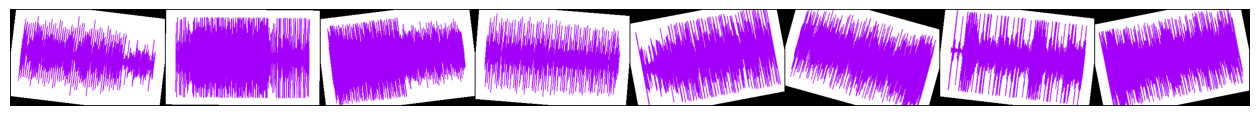

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [ ]:
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [00:05<00:00, 20.04it/s]


Epoch [0], val_loss: 1.8344, val_score: 0.3125


100%|██████████| 113/113 [00:07<00:00, 15.36it/s]


Epoch [1], val_loss: 1.8969, val_score: 0.3214


100%|██████████| 113/113 [00:05<00:00, 19.74it/s]


Epoch [2], val_loss: 1.8847, val_score: 0.2946


100%|██████████| 113/113 [00:07<00:00, 15.71it/s]


Epoch [3], val_loss: 1.7661, val_score: 0.3214


100%|██████████| 113/113 [00:05<00:00, 19.74it/s]


Epoch [4], val_loss: 1.8076, val_score: 0.3482


In [ ]:
history += train_model(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [00:06<00:00, 16.89it/s]


Epoch [0], val_loss: 1.7305, val_score: 0.3839


100%|██████████| 113/113 [00:06<00:00, 18.73it/s]


Epoch [1], val_loss: 1.7945, val_score: 0.3839


100%|██████████| 113/113 [00:07<00:00, 14.22it/s]


Epoch [2], val_loss: 1.7614, val_score: 0.3482


100%|██████████| 113/113 [00:08<00:00, 12.56it/s]


Epoch [3], val_loss: 1.7976, val_score: 0.3482


100%|██████████| 113/113 [00:06<00:00, 16.68it/s]


Epoch [4], val_loss: 1.8234, val_score: 0.3304


100%|██████████| 113/113 [00:09<00:00, 11.54it/s]


Epoch [5], val_loss: 1.7985, val_score: 0.3571


100%|██████████| 113/113 [00:08<00:00, 12.66it/s]


Epoch [6], val_loss: 1.8371, val_score: 0.3601


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


Epoch [7], val_loss: 1.7872, val_score: 0.3958


100%|██████████| 113/113 [00:07<00:00, 15.60it/s]


Epoch [8], val_loss: 1.8821, val_score: 0.2946


100%|██████████| 113/113 [00:07<00:00, 14.26it/s]


Epoch [9], val_loss: 1.8980, val_score: 0.3661


100%|██████████| 113/113 [00:06<00:00, 18.65it/s]


Epoch [10], val_loss: 2.0064, val_score: 0.3036


100%|██████████| 113/113 [00:07<00:00, 14.25it/s]


Epoch [11], val_loss: 1.9565, val_score: 0.3423


100%|██████████| 113/113 [00:05<00:00, 19.72it/s]


Epoch [12], val_loss: 1.8479, val_score: 0.3214


100%|██████████| 113/113 [00:07<00:00, 15.52it/s]


Epoch [13], val_loss: 1.9908, val_score: 0.3036


100%|██████████| 113/113 [00:05<00:00, 20.00it/s]


Epoch [14], val_loss: 1.9285, val_score: 0.3214


100%|██████████| 113/113 [00:07<00:00, 16.10it/s]


Epoch [15], val_loss: 1.9103, val_score: 0.3304


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [16], val_loss: 2.1302, val_score: 0.3333


100%|██████████| 113/113 [00:06<00:00, 16.63it/s]


Epoch [17], val_loss: 2.0282, val_score: 0.3393


100%|██████████| 113/113 [00:06<00:00, 18.22it/s]


Epoch [18], val_loss: 1.9023, val_score: 0.3690


100%|██████████| 113/113 [00:10<00:00, 10.39it/s]


Epoch [19], val_loss: 2.0037, val_score: 0.3750


100%|██████████| 113/113 [00:08<00:00, 13.09it/s]


Epoch [20], val_loss: 1.9535, val_score: 0.3661


100%|██████████| 113/113 [00:07<00:00, 15.66it/s]


Epoch [21], val_loss: 1.9790, val_score: 0.3929


100%|██████████| 113/113 [00:05<00:00, 19.78it/s]


Epoch [22], val_loss: 2.0001, val_score: 0.3482


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


Epoch [23], val_loss: 1.9988, val_score: 0.2857


100%|██████████| 113/113 [00:05<00:00, 19.89it/s]


Epoch [24], val_loss: 2.1091, val_score: 0.3125


100%|██████████| 113/113 [00:07<00:00, 15.49it/s]


Epoch [25], val_loss: 1.9152, val_score: 0.3661


100%|██████████| 113/113 [00:05<00:00, 19.81it/s]


Epoch [26], val_loss: 2.0072, val_score: 0.3661


100%|██████████| 113/113 [00:07<00:00, 15.47it/s]


Epoch [27], val_loss: 1.9823, val_score: 0.4405


100%|██████████| 113/113 [00:05<00:00, 20.06it/s]


Epoch [28], val_loss: 2.0866, val_score: 0.3304


100%|██████████| 113/113 [00:07<00:00, 15.40it/s]


Epoch [29], val_loss: 2.0921, val_score: 0.3393


100%|██████████| 113/113 [00:05<00:00, 19.90it/s]


Epoch [30], val_loss: 2.3843, val_score: 0.2857


100%|██████████| 113/113 [00:07<00:00, 15.38it/s]


Epoch [31], val_loss: 2.0406, val_score: 0.3929


100%|██████████| 113/113 [00:05<00:00, 19.91it/s]


Epoch [32], val_loss: 2.1584, val_score: 0.3482


100%|██████████| 113/113 [00:07<00:00, 15.74it/s]


Epoch [33], val_loss: 2.2297, val_score: 0.3423


100%|██████████| 113/113 [00:06<00:00, 17.24it/s]


Epoch [34], val_loss: 2.2002, val_score: 0.3661


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


Epoch [35], val_loss: 2.0550, val_score: 0.3661


100%|██████████| 113/113 [00:06<00:00, 16.92it/s]


Epoch [36], val_loss: 2.2398, val_score: 0.3512


100%|██████████| 113/113 [00:05<00:00, 19.93it/s]


Epoch [37], val_loss: 2.0514, val_score: 0.3214


100%|██████████| 113/113 [00:07<00:00, 15.46it/s]


Epoch [38], val_loss: 2.1125, val_score: 0.3214


100%|██████████| 113/113 [00:05<00:00, 19.81it/s]


Epoch [39], val_loss: 2.4683, val_score: 0.3571


100%|██████████| 113/113 [00:07<00:00, 15.17it/s]


Epoch [40], val_loss: 2.4080, val_score: 0.4137


100%|██████████| 113/113 [00:05<00:00, 19.83it/s]


Epoch [41], val_loss: 2.2986, val_score: 0.3393


100%|██████████| 113/113 [00:07<00:00, 15.35it/s]


Epoch [42], val_loss: 2.2555, val_score: 0.3393


100%|██████████| 113/113 [00:05<00:00, 19.94it/s]


Epoch [43], val_loss: 2.3802, val_score: 0.3125


100%|██████████| 113/113 [00:07<00:00, 15.47it/s]


Epoch [44], val_loss: 2.6132, val_score: 0.2768


100%|██████████| 113/113 [00:05<00:00, 19.80it/s]


Epoch [45], val_loss: 2.2731, val_score: 0.3869


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


Epoch [46], val_loss: 2.2017, val_score: 0.3601


100%|██████████| 113/113 [00:05<00:00, 19.80it/s]


Epoch [47], val_loss: 2.3812, val_score: 0.4048


100%|██████████| 113/113 [00:07<00:00, 14.13it/s]


Epoch [48], val_loss: 2.6626, val_score: 0.2857


100%|██████████| 113/113 [00:05<00:00, 19.51it/s]


Epoch [49], val_loss: 2.2628, val_score: 0.3482


100%|██████████| 113/113 [00:06<00:00, 16.74it/s]


Epoch [50], val_loss: 2.2905, val_score: 0.4315


100%|██████████| 113/113 [00:06<00:00, 17.67it/s]


Epoch [51], val_loss: 2.5581, val_score: 0.3482


100%|██████████| 113/113 [00:06<00:00, 18.76it/s]


Epoch [52], val_loss: 2.3644, val_score: 0.3958


100%|██████████| 113/113 [00:06<00:00, 16.71it/s]


Epoch [53], val_loss: 2.4912, val_score: 0.3750


100%|██████████| 113/113 [00:05<00:00, 19.91it/s]


Epoch [54], val_loss: 2.3155, val_score: 0.3661


100%|██████████| 113/113 [00:07<00:00, 15.92it/s]


Epoch [55], val_loss: 2.3027, val_score: 0.3750


100%|██████████| 113/113 [00:05<00:00, 19.60it/s]


Epoch [56], val_loss: 2.2559, val_score: 0.4226


100%|██████████| 113/113 [00:07<00:00, 15.41it/s]


Epoch [57], val_loss: 2.7423, val_score: 0.3393


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [58], val_loss: 2.5293, val_score: 0.4315


100%|██████████| 113/113 [00:07<00:00, 15.68it/s]


Epoch [59], val_loss: 2.6057, val_score: 0.3482


100%|██████████| 113/113 [00:05<00:00, 19.72it/s]


Epoch [60], val_loss: 2.1924, val_score: 0.4315


100%|██████████| 113/113 [00:07<00:00, 15.63it/s]


Epoch [61], val_loss: 2.1707, val_score: 0.3929


100%|██████████| 113/113 [00:05<00:00, 19.83it/s]


Epoch [62], val_loss: 2.5086, val_score: 0.3958


100%|██████████| 113/113 [00:07<00:00, 15.34it/s]


Epoch [63], val_loss: 2.4829, val_score: 0.3929


100%|██████████| 113/113 [00:05<00:00, 19.94it/s]


Epoch [64], val_loss: 2.4927, val_score: 0.3661


100%|██████████| 113/113 [00:07<00:00, 15.25it/s]


Epoch [65], val_loss: 2.6532, val_score: 0.3661


100%|██████████| 113/113 [00:05<00:00, 19.58it/s]


Epoch [66], val_loss: 2.5243, val_score: 0.4048


100%|██████████| 113/113 [00:07<00:00, 16.00it/s]


Epoch [67], val_loss: 2.5792, val_score: 0.3780


100%|██████████| 113/113 [00:05<00:00, 19.43it/s]


Epoch [68], val_loss: 2.4406, val_score: 0.4137


100%|██████████| 113/113 [00:06<00:00, 17.13it/s]


Epoch [69], val_loss: 2.5779, val_score: 0.3929


100%|██████████| 113/113 [00:06<00:00, 18.28it/s]


Epoch [70], val_loss: 2.5819, val_score: 0.3958


100%|██████████| 113/113 [00:06<00:00, 18.37it/s]


Epoch [71], val_loss: 2.4149, val_score: 0.4018


100%|██████████| 113/113 [00:06<00:00, 17.03it/s]


Epoch [72], val_loss: 2.2319, val_score: 0.4792


100%|██████████| 113/113 [00:05<00:00, 19.65it/s]


Epoch [73], val_loss: 2.4313, val_score: 0.3661


100%|██████████| 113/113 [00:06<00:00, 16.16it/s]


Epoch [74], val_loss: 2.3780, val_score: 0.3750


100%|██████████| 113/113 [00:05<00:00, 19.84it/s]


Epoch [75], val_loss: 2.3604, val_score: 0.3393


100%|██████████| 113/113 [00:07<00:00, 15.68it/s]


Epoch [76], val_loss: 2.3994, val_score: 0.3839


100%|██████████| 113/113 [00:05<00:00, 19.72it/s]


Epoch [77], val_loss: 2.5579, val_score: 0.4315


100%|██████████| 113/113 [00:07<00:00, 15.70it/s]


Epoch [78], val_loss: 2.7365, val_score: 0.3958


100%|██████████| 113/113 [00:05<00:00, 19.93it/s]


Epoch [79], val_loss: 2.5773, val_score: 0.4196


100%|██████████| 113/113 [00:07<00:00, 15.39it/s]


Epoch [80], val_loss: 2.3688, val_score: 0.4137


100%|██████████| 113/113 [00:05<00:00, 19.91it/s]


Epoch [81], val_loss: 2.6804, val_score: 0.3482


100%|██████████| 113/113 [00:07<00:00, 15.50it/s]


Epoch [82], val_loss: 2.3036, val_score: 0.3929


100%|██████████| 113/113 [00:05<00:00, 19.92it/s]


Epoch [83], val_loss: 2.4952, val_score: 0.3571


100%|██████████| 113/113 [00:07<00:00, 15.50it/s]


Epoch [84], val_loss: 2.4120, val_score: 0.3839


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [85], val_loss: 2.6015, val_score: 0.3482


100%|██████████| 113/113 [00:07<00:00, 15.61it/s]


Epoch [86], val_loss: 2.4608, val_score: 0.4048


100%|██████████| 113/113 [00:05<00:00, 19.96it/s]


Epoch [87], val_loss: 2.2741, val_score: 0.4018


100%|██████████| 113/113 [00:06<00:00, 16.63it/s]


Epoch [88], val_loss: 2.6054, val_score: 0.4315


100%|██████████| 113/113 [00:05<00:00, 18.93it/s]


Epoch [89], val_loss: 2.4200, val_score: 0.3869


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


Epoch [90], val_loss: 2.6005, val_score: 0.4315


100%|██████████| 113/113 [00:06<00:00, 17.33it/s]


Epoch [91], val_loss: 2.3891, val_score: 0.4405


100%|██████████| 113/113 [00:05<00:00, 19.18it/s]


Epoch [92], val_loss: 2.3886, val_score: 0.4137


100%|██████████| 113/113 [00:07<00:00, 15.83it/s]


Epoch [93], val_loss: 2.7619, val_score: 0.4048


100%|██████████| 113/113 [00:05<00:00, 19.61it/s]


Epoch [94], val_loss: 2.5381, val_score: 0.4048


100%|██████████| 113/113 [00:07<00:00, 15.28it/s]


Epoch [95], val_loss: 2.4806, val_score: 0.3750


100%|██████████| 113/113 [00:05<00:00, 19.82it/s]


Epoch [96], val_loss: 2.5116, val_score: 0.4315


100%|██████████| 113/113 [00:07<00:00, 15.44it/s]


Epoch [97], val_loss: 2.3186, val_score: 0.3929


100%|██████████| 113/113 [00:05<00:00, 19.78it/s]


Epoch [98], val_loss: 2.2976, val_score: 0.4494


100%|██████████| 113/113 [00:07<00:00, 15.30it/s]


Epoch [99], val_loss: 2.4544, val_score: 0.4137


In [ ]:
max_val_score = 0
for i in range(len(history)):
    if max_val_score < history[i]['val_score']:
        max_val_score = history[i]['val_score']

print('max val_score:', max_val_score)

max val_score: 0.4791666865348816


In [ ]:
torch.save(model.state_dict(), path + '/Models/wave_resnet_18.pth')

### Make prediction from spectrogram

In [ ]:
img_path = path + 'Data/spec_images'

train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([8, 3, 224, 363])


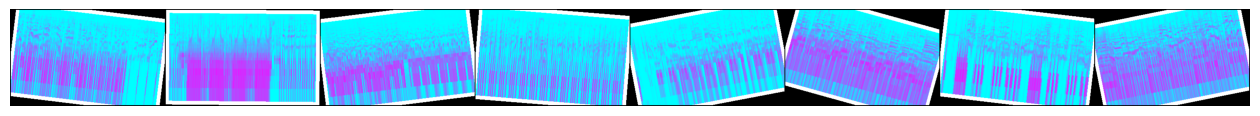

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [ ]:
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [02:08<00:00,  1.14s/it]


Epoch [0], val_loss: 1.8692, val_score: 0.4048


100%|██████████| 113/113 [00:07<00:00, 14.90it/s]


Epoch [1], val_loss: 1.5468, val_score: 0.4583


100%|██████████| 113/113 [00:06<00:00, 17.15it/s]


Epoch [2], val_loss: 1.3606, val_score: 0.5655


100%|██████████| 113/113 [00:08<00:00, 13.08it/s]


Epoch [3], val_loss: 1.2138, val_score: 0.6310


100%|██████████| 113/113 [00:06<00:00, 17.12it/s]


Epoch [4], val_loss: 1.2707, val_score: 0.5208


In [ ]:
history += train_model(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [00:05<00:00, 18.96it/s]


Epoch [0], val_loss: 1.1789, val_score: 0.6042


100%|██████████| 113/113 [00:07<00:00, 14.75it/s]


Epoch [1], val_loss: 1.2231, val_score: 0.5000


100%|██████████| 113/113 [00:05<00:00, 19.08it/s]


Epoch [2], val_loss: 1.1465, val_score: 0.6964


100%|██████████| 113/113 [00:07<00:00, 14.71it/s]


Epoch [3], val_loss: 1.1281, val_score: 0.6310


100%|██████████| 113/113 [00:06<00:00, 17.89it/s]


Epoch [4], val_loss: 1.1130, val_score: 0.6399


100%|██████████| 113/113 [00:07<00:00, 14.90it/s]


Epoch [5], val_loss: 1.1723, val_score: 0.5833


100%|██████████| 113/113 [00:07<00:00, 14.70it/s]


Epoch [6], val_loss: 1.1879, val_score: 0.5357


100%|██████████| 113/113 [00:05<00:00, 19.15it/s]


Epoch [7], val_loss: 1.1309, val_score: 0.6399


100%|██████████| 113/113 [00:07<00:00, 14.78it/s]


Epoch [8], val_loss: 1.0392, val_score: 0.6429


100%|██████████| 113/113 [00:06<00:00, 18.55it/s]


Epoch [9], val_loss: 1.0877, val_score: 0.6220


100%|██████████| 113/113 [00:07<00:00, 15.05it/s]


Epoch [10], val_loss: 1.1964, val_score: 0.5952


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


Epoch [11], val_loss: 1.2759, val_score: 0.5655


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


Epoch [12], val_loss: 1.2532, val_score: 0.6220


100%|██████████| 113/113 [00:06<00:00, 16.44it/s]


Epoch [13], val_loss: 1.2020, val_score: 0.6250


100%|██████████| 113/113 [00:05<00:00, 19.18it/s]


Epoch [14], val_loss: 1.0393, val_score: 0.7113


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


Epoch [15], val_loss: 1.5154, val_score: 0.5476


100%|██████████| 113/113 [00:05<00:00, 19.78it/s]


Epoch [16], val_loss: 1.1222, val_score: 0.7054


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


Epoch [17], val_loss: 1.4970, val_score: 0.5268


100%|██████████| 113/113 [00:05<00:00, 19.57it/s]


Epoch [18], val_loss: 1.0830, val_score: 0.6845


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


Epoch [19], val_loss: 1.0982, val_score: 0.6369


100%|██████████| 113/113 [00:05<00:00, 19.46it/s]


Epoch [20], val_loss: 1.2899, val_score: 0.5833


100%|██████████| 113/113 [00:07<00:00, 15.03it/s]


Epoch [21], val_loss: 1.2427, val_score: 0.5863


100%|██████████| 113/113 [00:06<00:00, 17.79it/s]


Epoch [22], val_loss: 0.9092, val_score: 0.7024


100%|██████████| 113/113 [00:06<00:00, 17.18it/s]


Epoch [23], val_loss: 1.1595, val_score: 0.6190


100%|██████████| 113/113 [00:06<00:00, 16.47it/s]


Epoch [24], val_loss: 1.2099, val_score: 0.6488


100%|██████████| 113/113 [00:05<00:00, 19.68it/s]


Epoch [25], val_loss: 1.1391, val_score: 0.6845


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


Epoch [26], val_loss: 1.0783, val_score: 0.6369


100%|██████████| 113/113 [00:05<00:00, 19.68it/s]


Epoch [27], val_loss: 0.9516, val_score: 0.6935


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


Epoch [28], val_loss: 0.9554, val_score: 0.7381


100%|██████████| 113/113 [00:05<00:00, 19.38it/s]


Epoch [29], val_loss: 1.1511, val_score: 0.5982


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


Epoch [30], val_loss: 1.0734, val_score: 0.6964


100%|██████████| 113/113 [00:05<00:00, 19.61it/s]


Epoch [31], val_loss: 1.0925, val_score: 0.6756


100%|██████████| 113/113 [00:07<00:00, 15.14it/s]


Epoch [32], val_loss: 0.9798, val_score: 0.6548


100%|██████████| 113/113 [00:05<00:00, 19.41it/s]


Epoch [33], val_loss: 1.1604, val_score: 0.6637


100%|██████████| 113/113 [00:06<00:00, 16.61it/s]


Epoch [34], val_loss: 0.9824, val_score: 0.6905


100%|██████████| 113/113 [00:06<00:00, 17.21it/s]


Epoch [35], val_loss: 0.9651, val_score: 0.7768


100%|██████████| 113/113 [00:05<00:00, 19.09it/s]


Epoch [36], val_loss: 1.0441, val_score: 0.6280


100%|██████████| 113/113 [00:07<00:00, 15.26it/s]


Epoch [37], val_loss: 1.1563, val_score: 0.6488


100%|██████████| 113/113 [00:05<00:00, 19.65it/s]


Epoch [38], val_loss: 1.1185, val_score: 0.6577


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


Epoch [39], val_loss: 0.9939, val_score: 0.7411


100%|██████████| 113/113 [00:05<00:00, 19.61it/s]


Epoch [40], val_loss: 0.9987, val_score: 0.6161


100%|██████████| 113/113 [00:07<00:00, 14.80it/s]


Epoch [41], val_loss: 1.0115, val_score: 0.6488


100%|██████████| 113/113 [00:05<00:00, 19.62it/s]


Epoch [42], val_loss: 1.0212, val_score: 0.6994


100%|██████████| 113/113 [00:07<00:00, 14.83it/s]


Epoch [43], val_loss: 1.2485, val_score: 0.6845


100%|██████████| 113/113 [00:05<00:00, 19.17it/s]


Epoch [44], val_loss: 1.0246, val_score: 0.5982


100%|██████████| 113/113 [00:06<00:00, 16.47it/s]


Epoch [45], val_loss: 1.2259, val_score: 0.6101


100%|██████████| 113/113 [00:06<00:00, 16.87it/s]


Epoch [46], val_loss: 1.0066, val_score: 0.7143


100%|██████████| 113/113 [00:06<00:00, 18.74it/s]


Epoch [47], val_loss: 1.0631, val_score: 0.6637


100%|██████████| 113/113 [00:07<00:00, 14.39it/s]


Epoch [48], val_loss: 0.8622, val_score: 0.7024


100%|██████████| 113/113 [00:05<00:00, 19.04it/s]


Epoch [49], val_loss: 1.1119, val_score: 0.5982


100%|██████████| 113/113 [00:07<00:00, 14.92it/s]


Epoch [50], val_loss: 0.8823, val_score: 0.7292


100%|██████████| 113/113 [00:05<00:00, 18.94it/s]


Epoch [51], val_loss: 1.0615, val_score: 0.6458


100%|██████████| 113/113 [00:07<00:00, 14.68it/s]


Epoch [52], val_loss: 1.0079, val_score: 0.6905


100%|██████████| 113/113 [00:05<00:00, 19.00it/s]


Epoch [53], val_loss: 1.0765, val_score: 0.6369


100%|██████████| 113/113 [00:06<00:00, 16.18it/s]


Epoch [54], val_loss: 0.9758, val_score: 0.6458


100%|██████████| 113/113 [00:06<00:00, 17.06it/s]


Epoch [55], val_loss: 0.9134, val_score: 0.6548


100%|██████████| 113/113 [00:06<00:00, 18.35it/s]


Epoch [56], val_loss: 0.9507, val_score: 0.7470


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


Epoch [57], val_loss: 0.9102, val_score: 0.6845


100%|██████████| 113/113 [00:05<00:00, 19.54it/s]


Epoch [58], val_loss: 0.7692, val_score: 0.8125


100%|██████████| 113/113 [00:07<00:00, 15.03it/s]


Epoch [59], val_loss: 0.9425, val_score: 0.7113


100%|██████████| 113/113 [00:05<00:00, 19.46it/s]


Epoch [60], val_loss: 0.9183, val_score: 0.7679


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


Epoch [61], val_loss: 0.8071, val_score: 0.8214


100%|██████████| 113/113 [00:05<00:00, 19.31it/s]


Epoch [62], val_loss: 0.8600, val_score: 0.7381


100%|██████████| 113/113 [00:07<00:00, 15.04it/s]


Epoch [63], val_loss: 1.0357, val_score: 0.6458


100%|██████████| 113/113 [00:05<00:00, 19.58it/s]


Epoch [64], val_loss: 0.9048, val_score: 0.7768


100%|██████████| 113/113 [00:06<00:00, 16.17it/s]


Epoch [65], val_loss: 0.7440, val_score: 0.8304


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


Epoch [66], val_loss: 0.8328, val_score: 0.7381


100%|██████████| 113/113 [00:06<00:00, 17.93it/s]


Epoch [67], val_loss: 0.8950, val_score: 0.6905


100%|██████████| 113/113 [00:07<00:00, 16.08it/s]


Epoch [68], val_loss: 0.8051, val_score: 0.7946


100%|██████████| 113/113 [00:05<00:00, 19.30it/s]


Epoch [69], val_loss: 0.8387, val_score: 0.7589


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


Epoch [70], val_loss: 0.7109, val_score: 0.7827


100%|██████████| 113/113 [00:05<00:00, 18.95it/s]


Epoch [71], val_loss: 0.7492, val_score: 0.7946


100%|██████████| 113/113 [00:07<00:00, 15.33it/s]


Epoch [72], val_loss: 0.7981, val_score: 0.8036


100%|██████████| 113/113 [00:05<00:00, 19.48it/s]


Epoch [73], val_loss: 0.7366, val_score: 0.8304


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


Epoch [74], val_loss: 0.7748, val_score: 0.7917


100%|██████████| 113/113 [00:05<00:00, 19.39it/s]


Epoch [75], val_loss: 0.7469, val_score: 0.8214


100%|██████████| 113/113 [00:07<00:00, 15.26it/s]


Epoch [76], val_loss: 0.7253, val_score: 0.7946


100%|██████████| 113/113 [00:06<00:00, 18.74it/s]


Epoch [77], val_loss: 0.7796, val_score: 0.8125


100%|██████████| 113/113 [00:06<00:00, 16.88it/s]


Epoch [78], val_loss: 0.7266, val_score: 0.8036


100%|██████████| 113/113 [00:06<00:00, 16.66it/s]


Epoch [79], val_loss: 0.7571, val_score: 0.8125


100%|██████████| 113/113 [00:05<00:00, 19.59it/s]


Epoch [80], val_loss: 0.7847, val_score: 0.7470


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


Epoch [81], val_loss: 0.8724, val_score: 0.7173


100%|██████████| 113/113 [00:05<00:00, 19.56it/s]


Epoch [82], val_loss: 0.7114, val_score: 0.8214


100%|██████████| 113/113 [00:07<00:00, 14.85it/s]


Epoch [83], val_loss: 0.7863, val_score: 0.8036


100%|██████████| 113/113 [00:05<00:00, 19.33it/s]


Epoch [84], val_loss: 0.7141, val_score: 0.7946


100%|██████████| 113/113 [00:07<00:00, 15.06it/s]


Epoch [85], val_loss: 0.6274, val_score: 0.8393


100%|██████████| 113/113 [00:05<00:00, 19.37it/s]


Epoch [86], val_loss: 0.7635, val_score: 0.8214


100%|██████████| 113/113 [00:07<00:00, 14.76it/s]


Epoch [87], val_loss: 0.7091, val_score: 0.8304


100%|██████████| 113/113 [00:05<00:00, 18.88it/s]


Epoch [88], val_loss: 0.7197, val_score: 0.8125


100%|██████████| 113/113 [00:06<00:00, 16.85it/s]


Epoch [89], val_loss: 0.7318, val_score: 0.8393


100%|██████████| 113/113 [00:06<00:00, 16.98it/s]


Epoch [90], val_loss: 0.6960, val_score: 0.8214


100%|██████████| 113/113 [00:06<00:00, 18.78it/s]


Epoch [91], val_loss: 0.7086, val_score: 0.8006


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


Epoch [92], val_loss: 0.6947, val_score: 0.8214


100%|██████████| 113/113 [00:05<00:00, 19.39it/s]


Epoch [93], val_loss: 0.8424, val_score: 0.6905


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


Epoch [94], val_loss: 0.7811, val_score: 0.7827


100%|██████████| 113/113 [00:05<00:00, 19.01it/s]


Epoch [95], val_loss: 0.7484, val_score: 0.8125


100%|██████████| 113/113 [00:07<00:00, 14.94it/s]


Epoch [96], val_loss: 0.6804, val_score: 0.8304


100%|██████████| 113/113 [00:05<00:00, 19.51it/s]


Epoch [97], val_loss: 0.6912, val_score: 0.8125


100%|██████████| 113/113 [00:07<00:00, 15.03it/s]


Epoch [98], val_loss: 0.7474, val_score: 0.7857


100%|██████████| 113/113 [00:05<00:00, 19.34it/s]


Epoch [99], val_loss: 0.6850, val_score: 0.7827


In [ ]:
max_val_score = 0
for i in range(len(history)):
    if max_val_score < history[i]['val_score']:
        max_val_score = history[i]['val_score']

print('max val_score:', max_val_score)

max val_score: 0.8392857313156128


In [ ]:
torch.save(model.state_dict(), path + '/Models/spec_resnet_18.pth')

### Make prediction from Zero Crossing Rate image

In [ ]:
img_path = path + 'Data/ZCR_images'

train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([8, 3, 224, 363])


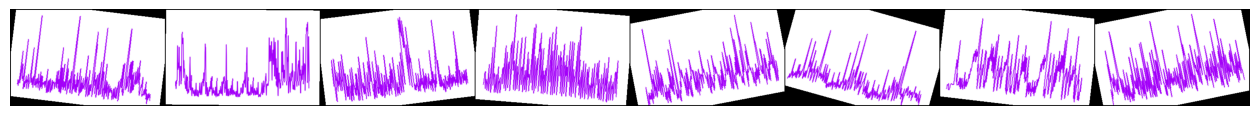

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [ ]:
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [02:02<00:00,  1.08s/it]


Epoch [0], val_loss: 1.9443, val_score: 0.3006


100%|██████████| 113/113 [00:05<00:00, 20.28it/s]


Epoch [1], val_loss: 1.9302, val_score: 0.3036


100%|██████████| 113/113 [00:07<00:00, 15.53it/s]


Epoch [2], val_loss: 1.9900, val_score: 0.3631


100%|██████████| 113/113 [00:05<00:00, 20.14it/s]


Epoch [3], val_loss: 2.0167, val_score: 0.4345


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


Epoch [4], val_loss: 1.9033, val_score: 0.3601


In [ ]:
history += train_model(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [00:05<00:00, 19.79it/s]


Epoch [0], val_loss: 1.9748, val_score: 0.3333


100%|██████████| 113/113 [00:07<00:00, 15.63it/s]


Epoch [1], val_loss: 2.0569, val_score: 0.2857


100%|██████████| 113/113 [00:05<00:00, 19.61it/s]


Epoch [2], val_loss: 1.9480, val_score: 0.4077


100%|██████████| 113/113 [00:07<00:00, 15.62it/s]


Epoch [3], val_loss: 1.9397, val_score: 0.3244


100%|██████████| 113/113 [00:05<00:00, 19.63it/s]


Epoch [4], val_loss: 2.0680, val_score: 0.2946


100%|██████████| 113/113 [00:07<00:00, 15.60it/s]


Epoch [5], val_loss: 1.9932, val_score: 0.3512


100%|██████████| 113/113 [00:05<00:00, 19.86it/s]


Epoch [6], val_loss: 2.0898, val_score: 0.3244


100%|██████████| 113/113 [00:07<00:00, 15.38it/s]


Epoch [7], val_loss: 2.0172, val_score: 0.4167


100%|██████████| 113/113 [00:05<00:00, 19.82it/s]


Epoch [8], val_loss: 1.9734, val_score: 0.3810


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


Epoch [9], val_loss: 2.1358, val_score: 0.3542


100%|██████████| 113/113 [00:05<00:00, 19.62it/s]


Epoch [10], val_loss: 2.0128, val_score: 0.4167


100%|██████████| 113/113 [00:07<00:00, 16.02it/s]


Epoch [11], val_loss: 2.0524, val_score: 0.3423


100%|██████████| 113/113 [00:05<00:00, 19.65it/s]


Epoch [12], val_loss: 2.1278, val_score: 0.3423


100%|██████████| 113/113 [00:06<00:00, 17.04it/s]


Epoch [13], val_loss: 2.3470, val_score: 0.3452


100%|██████████| 113/113 [00:06<00:00, 17.95it/s]


Epoch [14], val_loss: 2.2115, val_score: 0.3690


100%|██████████| 113/113 [00:06<00:00, 18.72it/s]


Epoch [15], val_loss: 2.2118, val_score: 0.3899


100%|██████████| 113/113 [00:06<00:00, 16.48it/s]


Epoch [16], val_loss: 2.2316, val_score: 0.3899


100%|██████████| 113/113 [00:05<00:00, 19.74it/s]


Epoch [17], val_loss: 2.2446, val_score: 0.3423


100%|██████████| 113/113 [00:07<00:00, 15.52it/s]


Epoch [18], val_loss: 2.3883, val_score: 0.2887


100%|██████████| 113/113 [00:05<00:00, 19.86it/s]


Epoch [19], val_loss: 2.0823, val_score: 0.4077


100%|██████████| 113/113 [00:07<00:00, 15.47it/s]


Epoch [20], val_loss: 2.2196, val_score: 0.3512


100%|██████████| 113/113 [00:05<00:00, 19.79it/s]


Epoch [21], val_loss: 2.3199, val_score: 0.3333


100%|██████████| 113/113 [00:07<00:00, 15.46it/s]


Epoch [22], val_loss: 2.2132, val_score: 0.2887


100%|██████████| 113/113 [00:05<00:00, 19.73it/s]


Epoch [23], val_loss: 2.4142, val_score: 0.3155


100%|██████████| 113/113 [00:07<00:00, 15.70it/s]


Epoch [24], val_loss: 2.2879, val_score: 0.2887


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [25], val_loss: 2.3452, val_score: 0.3244


100%|██████████| 113/113 [00:07<00:00, 15.57it/s]


Epoch [26], val_loss: 2.3173, val_score: 0.4077


100%|██████████| 113/113 [00:05<00:00, 19.84it/s]


Epoch [27], val_loss: 2.3161, val_score: 0.3631


100%|██████████| 113/113 [00:07<00:00, 15.41it/s]


Epoch [28], val_loss: 2.4488, val_score: 0.3363


100%|██████████| 113/113 [00:05<00:00, 19.82it/s]


Epoch [29], val_loss: 2.1586, val_score: 0.3810


100%|██████████| 113/113 [00:07<00:00, 16.05it/s]


Epoch [30], val_loss: 2.2954, val_score: 0.3631


100%|██████████| 113/113 [00:06<00:00, 18.60it/s]


Epoch [31], val_loss: 2.3263, val_score: 0.3333


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


Epoch [32], val_loss: 2.2284, val_score: 0.3899


100%|██████████| 113/113 [00:06<00:00, 16.85it/s]


Epoch [33], val_loss: 2.4021, val_score: 0.3452


100%|██████████| 113/113 [00:05<00:00, 19.78it/s]


Epoch [34], val_loss: 2.3466, val_score: 0.3036


100%|██████████| 113/113 [00:07<00:00, 15.93it/s]


Epoch [35], val_loss: 2.3734, val_score: 0.3363


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [36], val_loss: 2.2078, val_score: 0.3810


100%|██████████| 113/113 [00:07<00:00, 15.42it/s]


Epoch [37], val_loss: 2.3485, val_score: 0.3423


100%|██████████| 113/113 [00:05<00:00, 19.82it/s]


Epoch [38], val_loss: 2.2011, val_score: 0.3988


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


Epoch [39], val_loss: 2.2515, val_score: 0.3690


100%|██████████| 113/113 [00:05<00:00, 19.96it/s]


Epoch [40], val_loss: 2.2138, val_score: 0.3988


100%|██████████| 113/113 [00:07<00:00, 15.53it/s]


Epoch [41], val_loss: 2.7592, val_score: 0.3631


100%|██████████| 113/113 [00:05<00:00, 19.63it/s]


Epoch [42], val_loss: 2.3372, val_score: 0.3601


100%|██████████| 113/113 [00:07<00:00, 15.53it/s]


Epoch [43], val_loss: 2.4356, val_score: 0.2887


100%|██████████| 113/113 [00:05<00:00, 19.77it/s]


Epoch [44], val_loss: 2.1784, val_score: 0.4256


100%|██████████| 113/113 [00:07<00:00, 15.51it/s]


Epoch [45], val_loss: 2.4296, val_score: 0.3155


100%|██████████| 113/113 [00:05<00:00, 19.84it/s]


Epoch [46], val_loss: 2.5405, val_score: 0.3512


100%|██████████| 113/113 [00:06<00:00, 16.87it/s]


Epoch [47], val_loss: 2.2772, val_score: 0.3690


100%|██████████| 113/113 [00:06<00:00, 18.70it/s]


Epoch [48], val_loss: 2.2967, val_score: 0.3899


100%|██████████| 113/113 [00:06<00:00, 17.89it/s]


Epoch [49], val_loss: 2.3443, val_score: 0.3810


100%|██████████| 113/113 [00:06<00:00, 17.31it/s]


Epoch [50], val_loss: 2.2854, val_score: 0.3899


100%|██████████| 113/113 [00:05<00:00, 19.75it/s]


Epoch [51], val_loss: 2.2945, val_score: 0.3720


100%|██████████| 113/113 [00:06<00:00, 16.24it/s]


Epoch [52], val_loss: 2.3662, val_score: 0.3899


100%|██████████| 113/113 [00:05<00:00, 19.77it/s]


Epoch [53], val_loss: 2.4099, val_score: 0.4077


100%|██████████| 113/113 [00:07<00:00, 15.62it/s]


Epoch [54], val_loss: 2.5100, val_score: 0.2976


100%|██████████| 113/113 [00:05<00:00, 19.95it/s]


Epoch [55], val_loss: 2.2973, val_score: 0.4077


100%|██████████| 113/113 [00:07<00:00, 15.54it/s]


Epoch [56], val_loss: 2.5054, val_score: 0.3155


100%|██████████| 113/113 [00:05<00:00, 19.84it/s]


Epoch [57], val_loss: 2.3248, val_score: 0.3423


100%|██████████| 113/113 [00:07<00:00, 15.56it/s]


Epoch [58], val_loss: 2.4825, val_score: 0.3452


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [59], val_loss: 2.3823, val_score: 0.3988


100%|██████████| 113/113 [00:07<00:00, 15.44it/s]


Epoch [60], val_loss: 2.1960, val_score: 0.3988


100%|██████████| 113/113 [00:05<00:00, 19.94it/s]


Epoch [61], val_loss: 2.2612, val_score: 0.4345


100%|██████████| 113/113 [00:07<00:00, 15.44it/s]


Epoch [62], val_loss: 2.3584, val_score: 0.4167


100%|██████████| 113/113 [00:05<00:00, 19.87it/s]


Epoch [63], val_loss: 2.4394, val_score: 0.3363


100%|██████████| 113/113 [00:07<00:00, 15.98it/s]


Epoch [64], val_loss: 2.3095, val_score: 0.3899


100%|██████████| 113/113 [00:05<00:00, 19.84it/s]


Epoch [65], val_loss: 2.3808, val_score: 0.3988


100%|██████████| 113/113 [00:06<00:00, 17.19it/s]


Epoch [66], val_loss: 2.1744, val_score: 0.3601


100%|██████████| 113/113 [00:06<00:00, 17.98it/s]


Epoch [67], val_loss: 2.4263, val_score: 0.3958


100%|██████████| 113/113 [00:06<00:00, 18.66it/s]


Epoch [68], val_loss: 2.1713, val_score: 0.4167


100%|██████████| 113/113 [00:06<00:00, 16.82it/s]


Epoch [69], val_loss: 2.4251, val_score: 0.3810


100%|██████████| 113/113 [00:05<00:00, 19.92it/s]


Epoch [70], val_loss: 2.1908, val_score: 0.4256


100%|██████████| 113/113 [00:06<00:00, 16.24it/s]


Epoch [71], val_loss: 2.1143, val_score: 0.4077


100%|██████████| 113/113 [00:05<00:00, 19.82it/s]


Epoch [72], val_loss: 2.1132, val_score: 0.4613


100%|██████████| 113/113 [00:07<00:00, 15.49it/s]


Epoch [73], val_loss: 2.3144, val_score: 0.4435


100%|██████████| 113/113 [00:05<00:00, 19.80it/s]


Epoch [74], val_loss: 2.2310, val_score: 0.3958


100%|██████████| 113/113 [00:07<00:00, 15.39it/s]


Epoch [75], val_loss: 2.1807, val_score: 0.4613


100%|██████████| 113/113 [00:05<00:00, 19.99it/s]


Epoch [76], val_loss: 2.1497, val_score: 0.4524


100%|██████████| 113/113 [00:07<00:00, 15.49it/s]


Epoch [77], val_loss: 2.1504, val_score: 0.4256


100%|██████████| 113/113 [00:05<00:00, 19.92it/s]


Epoch [78], val_loss: 2.0150, val_score: 0.4881


100%|██████████| 113/113 [00:07<00:00, 15.58it/s]


Epoch [79], val_loss: 2.2016, val_score: 0.4524


100%|██████████| 113/113 [00:05<00:00, 19.96it/s]


Epoch [80], val_loss: 2.1426, val_score: 0.4345


100%|██████████| 113/113 [00:07<00:00, 15.39it/s]


Epoch [81], val_loss: 2.2964, val_score: 0.3869


100%|██████████| 113/113 [00:05<00:00, 19.91it/s]


Epoch [82], val_loss: 2.0238, val_score: 0.4256


100%|██████████| 113/113 [00:07<00:00, 15.49it/s]


Epoch [83], val_loss: 1.9731, val_score: 0.4881


100%|██████████| 113/113 [00:05<00:00, 19.86it/s]


Epoch [84], val_loss: 2.0867, val_score: 0.4077


100%|██████████| 113/113 [00:08<00:00, 12.99it/s]


Epoch [85], val_loss: 2.0077, val_score: 0.4524


100%|██████████| 113/113 [00:08<00:00, 12.66it/s]


Epoch [86], val_loss: 2.0820, val_score: 0.4435


100%|██████████| 113/113 [00:07<00:00, 15.87it/s]


Epoch [87], val_loss: 2.0763, val_score: 0.4613


100%|██████████| 113/113 [00:06<00:00, 16.62it/s]


Epoch [88], val_loss: 2.2149, val_score: 0.4524


100%|██████████| 113/113 [00:06<00:00, 18.46it/s]


Epoch [89], val_loss: 2.1409, val_score: 0.4524


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


Epoch [90], val_loss: 2.2062, val_score: 0.3899


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


Epoch [91], val_loss: 2.1137, val_score: 0.4970


100%|██████████| 113/113 [00:05<00:00, 19.56it/s]


Epoch [92], val_loss: 2.1084, val_score: 0.4345


100%|██████████| 113/113 [00:07<00:00, 16.04it/s]


Epoch [93], val_loss: 2.0226, val_score: 0.4524


100%|██████████| 113/113 [00:05<00:00, 19.61it/s]


Epoch [94], val_loss: 2.2169, val_score: 0.4613


100%|██████████| 113/113 [00:07<00:00, 15.45it/s]


Epoch [95], val_loss: 2.0627, val_score: 0.4345


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [96], val_loss: 2.1771, val_score: 0.4524


100%|██████████| 113/113 [00:07<00:00, 15.51it/s]


Epoch [97], val_loss: 2.1149, val_score: 0.4970


100%|██████████| 113/113 [00:05<00:00, 19.96it/s]


Epoch [98], val_loss: 2.0757, val_score: 0.4435


100%|██████████| 113/113 [00:07<00:00, 15.42it/s]


Epoch [99], val_loss: 2.0878, val_score: 0.4524


In [ ]:
max_val_score = 0
for i in range(len(history)):
    if max_val_score < history[i]['val_score']:
        max_val_score = history[i]['val_score']

print('max val_score:', max_val_score)

max val_score: 0.4970238208770752


In [ ]:
torch.save(model.state_dict(), path + '/Models/ZCR_resnet_18.pth')

### Make prediction from mfcc images

In [ ]:
img_path = path + 'Data/mfcc_images'

train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([8, 3, 224, 363])


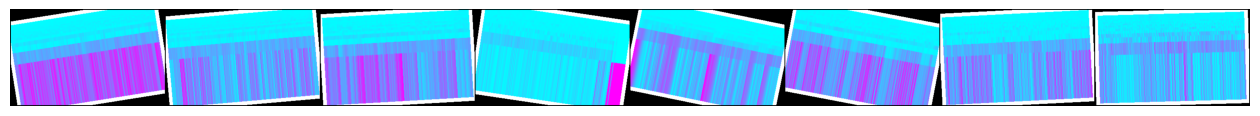

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [ ]:
history = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [00:06<00:00, 16.52it/s]


Epoch [0], val_loss: 1.9103, val_score: 0.3155


100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch [1], val_loss: 1.6823, val_score: 0.3393


100%|██████████| 113/113 [00:06<00:00, 16.90it/s]


Epoch [2], val_loss: 1.5873, val_score: 0.4494


100%|██████████| 113/113 [00:05<00:00, 19.04it/s]


Epoch [3], val_loss: 1.4264, val_score: 0.4911


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


Epoch [4], val_loss: 1.3445, val_score: 0.5208


In [ ]:
history += train_model(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

100%|██████████| 113/113 [00:05<00:00, 19.70it/s]


Epoch [0], val_loss: 1.3629, val_score: 0.5208


100%|██████████| 113/113 [00:10<00:00, 10.45it/s]


Epoch [1], val_loss: 1.3704, val_score: 0.5655


100%|██████████| 113/113 [00:08<00:00, 13.27it/s]


Epoch [2], val_loss: 1.3912, val_score: 0.5655


100%|██████████| 113/113 [00:05<00:00, 20.00it/s]


Epoch [3], val_loss: 1.3160, val_score: 0.5179


100%|██████████| 113/113 [00:06<00:00, 16.74it/s]


Epoch [4], val_loss: 1.2564, val_score: 0.5476


100%|██████████| 113/113 [00:05<00:00, 20.36it/s]


Epoch [5], val_loss: 1.2752, val_score: 0.5387


100%|██████████| 113/113 [00:06<00:00, 16.15it/s]


Epoch [6], val_loss: 1.2818, val_score: 0.5536


100%|██████████| 113/113 [00:05<00:00, 20.34it/s]


Epoch [7], val_loss: 1.3316, val_score: 0.5655


100%|██████████| 113/113 [00:07<00:00, 16.00it/s]


Epoch [8], val_loss: 1.1619, val_score: 0.6131


100%|██████████| 113/113 [00:05<00:00, 20.34it/s]


Epoch [9], val_loss: 1.2627, val_score: 0.6190


100%|██████████| 113/113 [00:07<00:00, 16.08it/s]


Epoch [10], val_loss: 1.3776, val_score: 0.5744


100%|██████████| 113/113 [00:05<00:00, 20.33it/s]


Epoch [11], val_loss: 1.2778, val_score: 0.5923


100%|██████████| 113/113 [00:07<00:00, 16.09it/s]


Epoch [12], val_loss: 1.3256, val_score: 0.5685


100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch [13], val_loss: 1.2884, val_score: 0.5476


100%|██████████| 113/113 [00:07<00:00, 15.71it/s]


Epoch [14], val_loss: 1.4543, val_score: 0.5655


100%|██████████| 113/113 [00:05<00:00, 20.27it/s]


Epoch [15], val_loss: 1.4199, val_score: 0.5387


100%|██████████| 113/113 [00:06<00:00, 16.96it/s]


Epoch [16], val_loss: 1.5147, val_score: 0.5387


100%|██████████| 113/113 [00:05<00:00, 20.33it/s]


Epoch [17], val_loss: 1.4902, val_score: 0.5119


100%|██████████| 113/113 [00:06<00:00, 16.94it/s]


Epoch [18], val_loss: 1.5577, val_score: 0.5208


100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch [19], val_loss: 1.3216, val_score: 0.6220


100%|██████████| 113/113 [00:06<00:00, 16.60it/s]


Epoch [20], val_loss: 1.4945, val_score: 0.5298


100%|██████████| 113/113 [00:05<00:00, 20.38it/s]


Epoch [21], val_loss: 1.7827, val_score: 0.5030


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


Epoch [22], val_loss: 1.5708, val_score: 0.5208


100%|██████████| 113/113 [00:05<00:00, 19.97it/s]


Epoch [23], val_loss: 1.8104, val_score: 0.4196


100%|██████████| 113/113 [00:06<00:00, 18.71it/s]


Epoch [24], val_loss: 1.6844, val_score: 0.5060


100%|██████████| 113/113 [00:06<00:00, 18.15it/s]


Epoch [25], val_loss: 1.3459, val_score: 0.5774


100%|██████████| 113/113 [00:05<00:00, 20.28it/s]


Epoch [26], val_loss: 1.5421, val_score: 0.5208


100%|██████████| 113/113 [00:06<00:00, 16.96it/s]


Epoch [27], val_loss: 1.8502, val_score: 0.5208


100%|██████████| 113/113 [00:05<00:00, 20.33it/s]


Epoch [28], val_loss: 1.5814, val_score: 0.5208


100%|██████████| 113/113 [00:06<00:00, 16.82it/s]


Epoch [29], val_loss: 1.4502, val_score: 0.5595


100%|██████████| 113/113 [00:05<00:00, 20.38it/s]


Epoch [30], val_loss: 1.6060, val_score: 0.5565


100%|██████████| 113/113 [00:06<00:00, 17.01it/s]


Epoch [31], val_loss: 1.6533, val_score: 0.5298


100%|██████████| 113/113 [00:05<00:00, 20.32it/s]


Epoch [32], val_loss: 1.6561, val_score: 0.5417


100%|██████████| 113/113 [00:06<00:00, 16.81it/s]


Epoch [33], val_loss: 1.5973, val_score: 0.5863


100%|██████████| 113/113 [00:05<00:00, 20.32it/s]


Epoch [34], val_loss: 1.5333, val_score: 0.5685


100%|██████████| 113/113 [00:06<00:00, 16.72it/s]


Epoch [35], val_loss: 1.4025, val_score: 0.5923


100%|██████████| 113/113 [00:05<00:00, 20.33it/s]


Epoch [36], val_loss: 1.6005, val_score: 0.5774


100%|██████████| 113/113 [00:06<00:00, 16.45it/s]


Epoch [37], val_loss: 1.7830, val_score: 0.5149


100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch [38], val_loss: 1.4635, val_score: 0.5685


100%|██████████| 113/113 [00:06<00:00, 17.72it/s]


Epoch [39], val_loss: 1.5371, val_score: 0.5952


100%|██████████| 113/113 [00:05<00:00, 19.57it/s]


Epoch [40], val_loss: 1.7627, val_score: 0.5595


100%|██████████| 113/113 [00:05<00:00, 19.08it/s]


Epoch [41], val_loss: 1.5587, val_score: 0.6131


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


Epoch [42], val_loss: 1.6174, val_score: 0.5923


100%|██████████| 113/113 [00:05<00:00, 20.33it/s]


Epoch [43], val_loss: 1.7171, val_score: 0.5238


100%|██████████| 113/113 [00:06<00:00, 16.63it/s]


Epoch [44], val_loss: 1.5071, val_score: 0.5565


100%|██████████| 113/113 [00:05<00:00, 20.30it/s]


Epoch [45], val_loss: 1.5544, val_score: 0.5923


100%|██████████| 113/113 [00:06<00:00, 16.77it/s]


Epoch [46], val_loss: 1.4880, val_score: 0.6012


100%|██████████| 113/113 [00:05<00:00, 20.32it/s]


Epoch [47], val_loss: 1.4305, val_score: 0.5923


100%|██████████| 113/113 [00:06<00:00, 16.71it/s]


Epoch [48], val_loss: 1.6732, val_score: 0.5774


100%|██████████| 113/113 [00:05<00:00, 20.36it/s]


Epoch [49], val_loss: 1.5363, val_score: 0.5685


100%|██████████| 113/113 [00:06<00:00, 16.58it/s]


Epoch [50], val_loss: 1.5290, val_score: 0.5774


100%|██████████| 113/113 [00:05<00:00, 20.26it/s]


Epoch [51], val_loss: 1.5216, val_score: 0.6310


100%|██████████| 113/113 [00:06<00:00, 16.75it/s]


Epoch [52], val_loss: 1.6529, val_score: 0.5506


100%|██████████| 113/113 [00:05<00:00, 20.38it/s]


Epoch [53], val_loss: 1.3861, val_score: 0.6667


100%|██████████| 113/113 [00:06<00:00, 16.33it/s]


Epoch [54], val_loss: 1.5354, val_score: 0.5774


100%|██████████| 113/113 [00:05<00:00, 20.33it/s]


Epoch [55], val_loss: 1.7365, val_score: 0.5238


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


Epoch [56], val_loss: 1.6410, val_score: 0.5298


100%|██████████| 113/113 [00:06<00:00, 18.56it/s]


Epoch [57], val_loss: 1.3179, val_score: 0.6310


100%|██████████| 113/113 [00:05<00:00, 19.57it/s]


Epoch [58], val_loss: 1.5455, val_score: 0.6220


100%|██████████| 113/113 [00:06<00:00, 17.08it/s]


Epoch [59], val_loss: 1.4868, val_score: 0.6250


100%|██████████| 113/113 [00:05<00:00, 20.29it/s]


Epoch [60], val_loss: 1.4018, val_score: 0.6607


100%|██████████| 113/113 [00:06<00:00, 16.59it/s]


Epoch [61], val_loss: 1.5119, val_score: 0.5387


100%|██████████| 113/113 [00:05<00:00, 20.34it/s]


Epoch [62], val_loss: 1.5012, val_score: 0.5952


100%|██████████| 113/113 [00:06<00:00, 16.45it/s]


Epoch [63], val_loss: 1.7381, val_score: 0.6131


100%|██████████| 113/113 [00:05<00:00, 20.27it/s]


Epoch [64], val_loss: 1.5243, val_score: 0.6399


100%|██████████| 113/113 [00:06<00:00, 16.59it/s]


Epoch [65], val_loss: 1.5048, val_score: 0.5952


100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch [66], val_loss: 1.5509, val_score: 0.6696


100%|██████████| 113/113 [00:07<00:00, 16.13it/s]


Epoch [67], val_loss: 1.6137, val_score: 0.6429


100%|██████████| 113/113 [00:05<00:00, 20.12it/s]


Epoch [68], val_loss: 1.7271, val_score: 0.5952


100%|██████████| 113/113 [00:06<00:00, 16.34it/s]


Epoch [69], val_loss: 1.7896, val_score: 0.5565


100%|██████████| 113/113 [00:05<00:00, 20.23it/s]


Epoch [70], val_loss: 1.4689, val_score: 0.6399


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


Epoch [71], val_loss: 1.5081, val_score: 0.6220


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


Epoch [72], val_loss: 1.5723, val_score: 0.6339


100%|██████████| 113/113 [00:05<00:00, 19.86it/s]


Epoch [73], val_loss: 1.3701, val_score: 0.6429


100%|██████████| 113/113 [00:06<00:00, 16.70it/s]


Epoch [74], val_loss: 1.6097, val_score: 0.5506


100%|██████████| 113/113 [00:05<00:00, 20.36it/s]


Epoch [75], val_loss: 1.5192, val_score: 0.6607


100%|██████████| 113/113 [00:07<00:00, 16.07it/s]


Epoch [76], val_loss: 1.5113, val_score: 0.5952


100%|██████████| 113/113 [00:05<00:00, 20.15it/s]


Epoch [77], val_loss: 1.5616, val_score: 0.6220


100%|██████████| 113/113 [00:06<00:00, 16.54it/s]


Epoch [78], val_loss: 1.5465, val_score: 0.6339


100%|██████████| 113/113 [00:05<00:00, 20.29it/s]


Epoch [79], val_loss: 1.4816, val_score: 0.6161


100%|██████████| 113/113 [00:06<00:00, 16.24it/s]


Epoch [80], val_loss: 1.4553, val_score: 0.6696


100%|██████████| 113/113 [00:05<00:00, 20.28it/s]


Epoch [81], val_loss: 1.5445, val_score: 0.6250


100%|██████████| 113/113 [00:06<00:00, 16.37it/s]


Epoch [82], val_loss: 1.5114, val_score: 0.6786


100%|██████████| 113/113 [00:05<00:00, 20.31it/s]


Epoch [83], val_loss: 1.4608, val_score: 0.6964


100%|██████████| 113/113 [00:06<00:00, 16.16it/s]


Epoch [84], val_loss: 1.5414, val_score: 0.6696


100%|██████████| 113/113 [00:05<00:00, 20.13it/s]


Epoch [85], val_loss: 1.4972, val_score: 0.6875


100%|██████████| 113/113 [00:06<00:00, 17.89it/s]


Epoch [86], val_loss: 1.3575, val_score: 0.6786


100%|██████████| 113/113 [00:06<00:00, 18.60it/s]


Epoch [87], val_loss: 1.4705, val_score: 0.6875


100%|██████████| 113/113 [00:05<00:00, 19.88it/s]


Epoch [88], val_loss: 1.4470, val_score: 0.6875


100%|██████████| 113/113 [00:06<00:00, 16.55it/s]


Epoch [89], val_loss: 1.5016, val_score: 0.7054


100%|██████████| 113/113 [00:05<00:00, 19.91it/s]


Epoch [90], val_loss: 1.4225, val_score: 0.6875


100%|██████████| 113/113 [00:07<00:00, 16.14it/s]


Epoch [91], val_loss: 1.4615, val_score: 0.5863


100%|██████████| 113/113 [00:05<00:00, 20.27it/s]


Epoch [92], val_loss: 1.4749, val_score: 0.6875


100%|██████████| 113/113 [00:06<00:00, 16.21it/s]


Epoch [93], val_loss: 1.4330, val_score: 0.6786


100%|██████████| 113/113 [00:05<00:00, 20.18it/s]


Epoch [94], val_loss: 1.4289, val_score: 0.6786


100%|██████████| 113/113 [00:06<00:00, 16.37it/s]


Epoch [95], val_loss: 1.4106, val_score: 0.6696


100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch [96], val_loss: 1.5578, val_score: 0.6250


100%|██████████| 113/113 [00:06<00:00, 16.27it/s]


Epoch [97], val_loss: 1.4327, val_score: 0.6607


100%|██████████| 113/113 [00:05<00:00, 20.26it/s]


Epoch [98], val_loss: 1.4878, val_score: 0.6429


100%|██████████| 113/113 [00:06<00:00, 16.89it/s]


Epoch [99], val_loss: 1.4630, val_score: 0.6607


In [ ]:
max_val_score = 0
for i in range(len(history)):
    if max_val_score < history[i]['val_score']:
        max_val_score = history[i]['val_score']

print('max val_score:', max_val_score)

max val_score: 0.7053571343421936


In [ ]:
torch.save(model.state_dict(), path + '/Models/mfcc_resnet_18.pth')

## MFCC time series

### Create LSTM model

In [ ]:
json_path = path + 'Data/mfcc.json'

In [ ]:
def load_data(data_path):
    print('Data loading')
    with open(data_path, 'r') as fp:
        data = json.load(fp)
    x = np.array(data['mfcc'])
    y = np.array(data['labels'])
    print('Loaded Data')
    return x, y

In [ ]:
x, y = load_data(json_path)

Data loading
Loaded Data


In [ ]:
x.shape

(999, 1290, 13)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))

In [ ]:
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
class RNN(nn.Module):
    def __init__(self, output_size, input_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]

        out = self.relu(self.fc1(lstm_out))
        out = self.fc2(out)
        out = self.softmax(out)

        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

### Make prediction from LSTM series

In [ ]:
output_size = 10
input_dim = 13
hidden_dim = 32
n_layers = 2

model = RNN(output_size, input_dim, hidden_dim, n_layers)
model.to(device)

lr=0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 100
counter = 0
print_every = 5
clip = 5

model.train()
for i in range(epochs):
    # Training 
    h = model.init_hidden(batch_size)
    train_losses = []
    model.train()
    train_accuracy = []
    
    for inputs, labels in train_loader:
        if inputs.shape[0] != batch_size:
            continue
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output, labels)
        train_losses.append(loss.item())
        pred = torch.argmax(output, dim=1)
        accuracy = accuracy_score(pred.cpu(), labels.cpu())
        train_accuracy.append(accuracy)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # Validation
    val_h = model.init_hidden(batch_size)
    val_losses = []
    model.eval()
    val_accuracy = []

    for inp, lab in val_loader:
        if inp.shape[0] != batch_size:
            continue
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        val_loss = criterion(out, lab)
        val_losses.append(val_loss.item())
        pred = torch.argmax(out, dim=1)
        accuracy = accuracy_score(pred.cpu(), lab.cpu())
        val_accuracy.append(accuracy)
            
        
    print("Epoch: {}/{}\t".format(i+1, epochs),
            "Train Loss: {:.6f}\t".format(loss.item()),
            "Train Accuracy: {:.4f}\t".format(np.mean(train_accuracy)),
            "Val Loss: {:.6f}\t".format(np.mean(val_losses)),
            "Val Accuracy: {:.4f}\t".format(np.mean(val_accuracy)))
    if val_loss <= min(val_losses):
        torch.save(model.state_dict(), './state_dict.pt')

Epoch: 1/100	 Train Loss: 2.302246	 Train Accuracy: 0.1038	 Val Loss: 2.301399	 Val Accuracy: 0.0625	
Epoch: 2/100	 Train Loss: 2.296320	 Train Accuracy: 0.1060	 Val Loss: 2.296158	 Val Accuracy: 0.1250	
Epoch: 3/100	 Train Loss: 2.280163	 Train Accuracy: 0.2243	 Val Loss: 2.281487	 Val Accuracy: 0.1875	
Epoch: 4/100	 Train Loss: 2.269737	 Train Accuracy: 0.2031	 Val Loss: 2.254877	 Val Accuracy: 0.1719	
Epoch: 5/100	 Train Loss: 2.212194	 Train Accuracy: 0.2321	 Val Loss: 2.211026	 Val Accuracy: 0.2812	
Epoch: 6/100	 Train Loss: 2.161672	 Train Accuracy: 0.2779	 Val Loss: 2.168023	 Val Accuracy: 0.2812	
Epoch: 7/100	 Train Loss: 2.123073	 Train Accuracy: 0.2824	 Val Loss: 2.132094	 Val Accuracy: 0.3125	
Epoch: 8/100	 Train Loss: 2.097856	 Train Accuracy: 0.3114	 Val Loss: 2.106510	 Val Accuracy: 0.3750	
Epoch: 9/100	 Train Loss: 2.172632	 Train Accuracy: 0.3315	 Val Loss: 2.103770	 Val Accuracy: 0.4062	
Epoch: 10/100	 Train Loss: 2.026201	 Train Accuracy: 0.3638	 Val Loss: 2.070420	 V

In [ ]:
print('max val accuracy:', max(val_accuracy))

max val accuracy: 0.421875


# Multi-modality

## Dataset and model defination

In [ ]:
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, img_type, transform=None):
        self.path = '/content/drive/MyDrive/Colab Notebooks/642Project/Data/'

        self.img_path = self.path + img_type
        self.json_path = self.path + 'mfcc_each_genre.json'

        files = os.listdir(self.img_path)
        self.file_names = [f for f in files if os.path.isfile(os.path.join(self.img_path, f))]

        with open(self.json_path, 'r') as f:
            self.mfcc = json.load(f)

        self.genre2label = {'blues': 0, 
                          'classical': 1, 
                          'country': 2, 
                          'disco': 3, 
                          'hiphop': 4, 
                          'jazz': 5, 
                          'metal': 6, 
                          'pop': 7, 
                          'reggae': 8, 
                          'rock': 9}
        self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

        
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        genre = img_name.split('.')[0]
        image = Image.open(os.path.join(self.img_path, img_name)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        wave_name = img_name[:-4] + '.wav'
        mfcc = np.array(self.mfcc[genre][wave_name]).astype('float32')

        return image, torch.from_numpy(mfcc), self.genre2label[genre]

    def __len__(self):
        return len(self.file_names)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class MusicMultiModalModel(nn.Module):
    def __init__(self, hidden_size):
        super(MusicMultiModalModel, self).__init__()

        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Identity() # remove the final fully-connected layer of ResNet18

        self.lstm = nn.LSTM(input_size=13, hidden_size=hidden_size, num_layers=2, batch_first=True)

        self.fc1 = nn.Linear(512 + hidden_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.norm_resnet = nn.LayerNorm(512)
        self.norm_lstm = nn.LayerNorm(hidden_size)

    def forward(self, x_img, x_mfcc):
        # pass the image through the ResNet18 model to get the feature map
        x_img = self.resnet(x_img)

        # pass the MFCCs through the LSTM to get the final hidden state
        _, (h_n, _) = self.lstm(x_mfcc)

        # x_img = self.norm_resnet(x_img)
        # h_n = self.norm_lstm(h_n[-1])

        # concatenate the ResNet18 and LSTM features
        x = torch.cat((x_img, h_n[-1]), dim=1)

        # pass the concatenated features through the fully-connected layer to get the output
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

## Make prediction from wave image and MFCC time series

In [ ]:
train_trms = T.Compose([
                        T.Resize((224, 224)),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])

# set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# create a dataset object for the full dataset
full_dataset = MusicDataset('wave_images', transform = train_trms)

# split the dataset into training and validation sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
model = MusicMultiModalModel(hidden_size=32)

# move the model to the device
model.to(device)

MusicMultiModalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
from tqdm import tqdm

# define the loss function
criterion = nn.CrossEntropyLoss()

# set the number of epochs to train for
num_epochs = 50
weight_decay = 5e-3
grad_clip = 0.3

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))

min_val_loss = float('inf')
max_val_accuracy = 0

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # initialize the running loss and number of correct predictions
    running_loss = 0.0
    num_correct = 0

    # iterate over the training data
    for images, mfccs, genres in train_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # update the model parameters
        optimizer.step()
        sched.step()

        # update the running loss
        running_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = num_correct / len(train_dataset)

    # set the model to evaluation mode
    model.eval()

    # initialize the running validation loss and number of correct predictions
    running_val_loss = 0.0
    num_correct = 0

    # iterate over the validation data
    for images, mfccs, genres in val_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update the validation loss
        running_val_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = num_correct / len(val_dataset)

    # print the loss and accuracy metrics for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}\n')

    if epoch_val_loss <= min_val_loss:
        min_val_loss = min(epoch_val_loss, min_val_loss)
        torch.save(model.state_dict(), path + 'Models/mfcc_multimodal.pt')
    max_val_accuracy = max(max_val_accuracy, epoch_val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-27-e245081bef96>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)
<ipython-input-27-e245081bef96>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)
  2%|▏         | 1/50 [00:20<16:31, 20.23s/it]

Epoch 1/50
Training Loss: 2.3078, Training Accuracy: 0.1402
Validation Loss: 2.2406, Validation Accuracy: 0.1900



  4%|▍         | 2/50 [00:29<11:05, 13.85s/it]

Epoch 2/50
Training Loss: 2.2252, Training Accuracy: 0.2102
Validation Loss: 2.1536, Validation Accuracy: 0.2700



  6%|▌         | 3/50 [00:39<09:33, 12.20s/it]

Epoch 3/50
Training Loss: 2.1111, Training Accuracy: 0.2848
Validation Loss: 2.0479, Validation Accuracy: 0.3000



  8%|▊         | 4/50 [00:50<08:46, 11.44s/it]

Epoch 4/50
Training Loss: 1.9889, Training Accuracy: 0.3359
Validation Loss: 1.8953, Validation Accuracy: 0.4700



 10%|█         | 5/50 [00:59<08:09, 10.87s/it]

Epoch 5/50
Training Loss: 1.8469, Training Accuracy: 0.3793
Validation Loss: 1.6753, Validation Accuracy: 0.4600



 12%|█▏        | 6/50 [01:09<07:40, 10.47s/it]

Epoch 6/50
Training Loss: 1.7075, Training Accuracy: 0.4138
Validation Loss: 1.5736, Validation Accuracy: 0.4300



 14%|█▍        | 7/50 [01:19<07:23, 10.33s/it]

Epoch 7/50
Training Loss: 1.6077, Training Accuracy: 0.4338
Validation Loss: 1.5951, Validation Accuracy: 0.4700



 16%|█▌        | 8/50 [01:29<07:06, 10.16s/it]

Epoch 8/50
Training Loss: 1.5337, Training Accuracy: 0.4727
Validation Loss: 1.5760, Validation Accuracy: 0.5000



 18%|█▊        | 9/50 [01:38<06:46,  9.91s/it]

Epoch 9/50
Training Loss: 1.4635, Training Accuracy: 0.4928
Validation Loss: 1.5637, Validation Accuracy: 0.4100



 20%|██        | 10/50 [01:48<06:37,  9.93s/it]

Epoch 10/50
Training Loss: 1.4274, Training Accuracy: 0.4917
Validation Loss: 1.6578, Validation Accuracy: 0.4400



 22%|██▏       | 11/50 [01:58<06:27,  9.93s/it]

Epoch 11/50
Training Loss: 1.3455, Training Accuracy: 0.5261
Validation Loss: 1.7314, Validation Accuracy: 0.4300



 24%|██▍       | 12/50 [02:08<06:16,  9.90s/it]

Epoch 12/50
Training Loss: 1.3242, Training Accuracy: 0.5395
Validation Loss: 1.7722, Validation Accuracy: 0.4100



 26%|██▌       | 13/50 [02:17<05:58,  9.68s/it]

Epoch 13/50
Training Loss: 1.3061, Training Accuracy: 0.5495
Validation Loss: 1.8397, Validation Accuracy: 0.3400



 28%|██▊       | 14/50 [02:27<05:51,  9.77s/it]

Epoch 14/50
Training Loss: 1.1676, Training Accuracy: 0.5829
Validation Loss: 1.8495, Validation Accuracy: 0.3800



 30%|███       | 15/50 [02:37<05:43,  9.80s/it]

Epoch 15/50
Training Loss: 1.1000, Training Accuracy: 0.6029
Validation Loss: 2.0139, Validation Accuracy: 0.4000



 32%|███▏      | 16/50 [02:46<05:27,  9.64s/it]

Epoch 16/50
Training Loss: 1.0932, Training Accuracy: 0.6196
Validation Loss: 2.0003, Validation Accuracy: 0.3600



 34%|███▍      | 17/50 [02:56<05:20,  9.70s/it]

Epoch 17/50
Training Loss: 0.9423, Training Accuracy: 0.6719
Validation Loss: 1.6471, Validation Accuracy: 0.4700



 36%|███▌      | 18/50 [03:06<05:13,  9.78s/it]

Epoch 18/50
Training Loss: 0.9139, Training Accuracy: 0.6930
Validation Loss: 2.0342, Validation Accuracy: 0.4200



 38%|███▊      | 19/50 [03:16<05:03,  9.78s/it]

Epoch 19/50
Training Loss: 0.8350, Training Accuracy: 0.7152
Validation Loss: 2.1666, Validation Accuracy: 0.4000



 40%|████      | 20/50 [03:25<04:49,  9.67s/it]

Epoch 20/50
Training Loss: 0.6762, Training Accuracy: 0.7742
Validation Loss: 1.9733, Validation Accuracy: 0.4100



 42%|████▏     | 21/50 [03:35<04:42,  9.75s/it]

Epoch 21/50
Training Loss: 0.6110, Training Accuracy: 0.7898
Validation Loss: 2.0007, Validation Accuracy: 0.5000



 44%|████▍     | 22/50 [03:45<04:34,  9.79s/it]

Epoch 22/50
Training Loss: 0.5217, Training Accuracy: 0.8432
Validation Loss: 2.2804, Validation Accuracy: 0.4600



 46%|████▌     | 23/50 [03:55<04:20,  9.65s/it]

Epoch 23/50
Training Loss: 0.4531, Training Accuracy: 0.8543
Validation Loss: 2.1999, Validation Accuracy: 0.4000



 48%|████▊     | 24/50 [04:04<04:11,  9.66s/it]

Epoch 24/50
Training Loss: 0.3719, Training Accuracy: 0.8932
Validation Loss: 2.4474, Validation Accuracy: 0.4000



 50%|█████     | 25/50 [04:14<04:04,  9.77s/it]

Epoch 25/50
Training Loss: 0.3468, Training Accuracy: 0.8999
Validation Loss: 2.1064, Validation Accuracy: 0.4900



 52%|█████▏    | 26/50 [04:24<03:56,  9.85s/it]

Epoch 26/50
Training Loss: 0.2841, Training Accuracy: 0.9088
Validation Loss: 2.2906, Validation Accuracy: 0.4700



 54%|█████▍    | 27/50 [04:34<03:42,  9.65s/it]

Epoch 27/50
Training Loss: 0.2965, Training Accuracy: 0.9077
Validation Loss: 2.4523, Validation Accuracy: 0.4500



 56%|█████▌    | 28/50 [04:43<03:34,  9.74s/it]

Epoch 28/50
Training Loss: 0.2360, Training Accuracy: 0.9266
Validation Loss: 2.3654, Validation Accuracy: 0.4600



 58%|█████▊    | 29/50 [04:53<03:26,  9.81s/it]

Epoch 29/50
Training Loss: 0.1952, Training Accuracy: 0.9399
Validation Loss: 2.4757, Validation Accuracy: 0.4100



 60%|██████    | 30/50 [05:03<03:13,  9.68s/it]

Epoch 30/50
Training Loss: 0.1552, Training Accuracy: 0.9566
Validation Loss: 2.4244, Validation Accuracy: 0.4700



 62%|██████▏   | 31/50 [05:12<03:03,  9.67s/it]

Epoch 31/50
Training Loss: 0.1801, Training Accuracy: 0.9377
Validation Loss: 2.4578, Validation Accuracy: 0.4800



 64%|██████▍   | 32/50 [05:22<02:55,  9.73s/it]

Epoch 32/50
Training Loss: 0.1695, Training Accuracy: 0.9566
Validation Loss: 2.3567, Validation Accuracy: 0.4300



 66%|██████▌   | 33/50 [05:32<02:45,  9.75s/it]

Epoch 33/50
Training Loss: 0.1173, Training Accuracy: 0.9700
Validation Loss: 2.3224, Validation Accuracy: 0.4800



 68%|██████▊   | 34/50 [05:41<02:32,  9.56s/it]

Epoch 34/50
Training Loss: 0.0971, Training Accuracy: 0.9722
Validation Loss: 2.2287, Validation Accuracy: 0.4600



 70%|███████   | 35/50 [05:51<02:25,  9.68s/it]

Epoch 35/50
Training Loss: 0.0666, Training Accuracy: 0.9933
Validation Loss: 2.2490, Validation Accuracy: 0.4500



 72%|███████▏  | 36/50 [06:01<02:16,  9.77s/it]

Epoch 36/50
Training Loss: 0.0512, Training Accuracy: 0.9933
Validation Loss: 2.3266, Validation Accuracy: 0.4900



 74%|███████▍  | 37/50 [06:11<02:05,  9.66s/it]

Epoch 37/50
Training Loss: 0.0510, Training Accuracy: 0.9933
Validation Loss: 2.5806, Validation Accuracy: 0.4300



 76%|███████▌  | 38/50 [06:20<01:56,  9.69s/it]

Epoch 38/50
Training Loss: 0.0389, Training Accuracy: 0.9967
Validation Loss: 2.4430, Validation Accuracy: 0.4900



 78%|███████▊  | 39/50 [06:30<01:47,  9.73s/it]

Epoch 39/50
Training Loss: 0.0425, Training Accuracy: 0.9933
Validation Loss: 2.3616, Validation Accuracy: 0.4700



 80%|████████  | 40/50 [06:40<01:37,  9.75s/it]

Epoch 40/50
Training Loss: 0.0349, Training Accuracy: 0.9911
Validation Loss: 2.5574, Validation Accuracy: 0.5100



 82%|████████▏ | 41/50 [06:49<01:26,  9.57s/it]

Epoch 41/50
Training Loss: 0.0391, Training Accuracy: 0.9944
Validation Loss: 2.6403, Validation Accuracy: 0.4200



 84%|████████▍ | 42/50 [06:59<01:17,  9.69s/it]

Epoch 42/50
Training Loss: 0.0325, Training Accuracy: 0.9944
Validation Loss: 2.3268, Validation Accuracy: 0.5200



 86%|████████▌ | 43/50 [07:09<01:08,  9.75s/it]

Epoch 43/50
Training Loss: 0.0416, Training Accuracy: 0.9911
Validation Loss: 2.4722, Validation Accuracy: 0.4900



 88%|████████▊ | 44/50 [07:18<00:57,  9.63s/it]

Epoch 44/50
Training Loss: 0.0360, Training Accuracy: 0.9956
Validation Loss: 2.5474, Validation Accuracy: 0.4600



 90%|█████████ | 45/50 [07:28<00:48,  9.66s/it]

Epoch 45/50
Training Loss: 0.0290, Training Accuracy: 0.9933
Validation Loss: 2.4582, Validation Accuracy: 0.5000



 92%|█████████▏| 46/50 [07:38<00:38,  9.74s/it]

Epoch 46/50
Training Loss: 0.0304, Training Accuracy: 0.9956
Validation Loss: 2.4673, Validation Accuracy: 0.4800



 94%|█████████▍| 47/50 [07:48<00:29,  9.76s/it]

Epoch 47/50
Training Loss: 0.0317, Training Accuracy: 0.9967
Validation Loss: 2.4966, Validation Accuracy: 0.4400



 96%|█████████▌| 48/50 [07:57<00:19,  9.57s/it]

Epoch 48/50
Training Loss: 0.0300, Training Accuracy: 0.9933
Validation Loss: 2.6042, Validation Accuracy: 0.4300



 98%|█████████▊| 49/50 [08:07<00:09,  9.66s/it]

Epoch 49/50
Training Loss: 0.0292, Training Accuracy: 0.9956
Validation Loss: 2.4001, Validation Accuracy: 0.4900



100%|██████████| 50/50 [08:17<00:00,  9.94s/it]

Epoch 50/50
Training Loss: 0.0299, Training Accuracy: 0.9956
Validation Loss: 2.3705, Validation Accuracy: 0.4700



In [ ]:
print('max val_score:', max_val_accuracy)

max val_score: 0.65


## Make prediction from spectrogram and MFCC time series

In [ ]:
train_trms = T.Compose([
                        T.Resize((224, 224)),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])

# set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# create a dataset object for the full dataset
full_dataset = MusicDataset('spec_images', transform = train_trms)

# split the dataset into training and validation sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
model = MusicMultiModalModel(hidden_size=32)

# move the model to the device
model.to(device)

MusicMultiModalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
from tqdm import tqdm

# define the loss function
criterion = nn.CrossEntropyLoss()

# set the number of epochs to train for
num_epochs = 50
weight_decay = 5e-3
grad_clip = 0.3

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))

min_val_loss = float('inf')
max_val_accuracy = 0

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # initialize the running loss and number of correct predictions
    running_loss = 0.0
    num_correct = 0

    # iterate over the training data
    for images, mfccs, genres in train_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # update the model parameters
        optimizer.step()
        sched.step()

        # update the running loss
        running_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = num_correct / len(train_dataset)

    # set the model to evaluation mode
    model.eval()

    # initialize the running validation loss and number of correct predictions
    running_val_loss = 0.0
    num_correct = 0

    # iterate over the validation data
    for images, mfccs, genres in val_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update the validation loss
        running_val_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = num_correct / len(val_dataset)

    # print the loss and accuracy metrics for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}\n')

    if epoch_val_loss <= min_val_loss:
        min_val_loss = min(epoch_val_loss, min_val_loss)
        torch.save(model.state_dict(), path + 'Models/spec_multimodal.pt')
    max_val_accuracy = max(max_val_accuracy, epoch_val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-22-35712c3bc9cd>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)
<ipython-input-22-35712c3bc9cd>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)


Epoch 1/50
Training Loss: 2.3120, Training Accuracy: 0.0879
Validation Loss: 2.2827, Validation Accuracy: 0.1200



  2%|▏         | 1/50 [00:20<16:35, 20.32s/it]

Epoch 2/50
Training Loss: 2.2704, Training Accuracy: 0.1669
Validation Loss: 2.2247, Validation Accuracy: 0.2000



  6%|▌         | 3/50 [00:41<09:53, 12.64s/it]

Epoch 3/50
Training Loss: 2.1911, Training Accuracy: 0.2603
Validation Loss: 2.1141, Validation Accuracy: 0.3000



  8%|▊         | 4/50 [00:51<09:04, 11.84s/it]

Epoch 4/50
Training Loss: 2.0225, Training Accuracy: 0.3526
Validation Loss: 1.9029, Validation Accuracy: 0.3400



 10%|█         | 5/50 [01:02<08:32, 11.38s/it]

Epoch 5/50
Training Loss: 1.7832, Training Accuracy: 0.4160
Validation Loss: 1.6857, Validation Accuracy: 0.4300



 12%|█▏        | 6/50 [01:12<08:00, 10.92s/it]

Epoch 6/50
Training Loss: 1.5390, Training Accuracy: 0.5406
Validation Loss: 1.4602, Validation Accuracy: 0.5100



 14%|█▍        | 7/50 [01:23<07:49, 10.92s/it]

Epoch 7/50
Training Loss: 1.2710, Training Accuracy: 0.6162
Validation Loss: 1.1911, Validation Accuracy: 0.6300



 16%|█▌        | 8/50 [01:34<07:37, 10.90s/it]

Epoch 8/50
Training Loss: 1.1214, Training Accuracy: 0.6574
Validation Loss: 1.1280, Validation Accuracy: 0.6200



 18%|█▊        | 9/50 [01:44<07:22, 10.78s/it]

Epoch 9/50
Training Loss: 0.9116, Training Accuracy: 0.7264
Validation Loss: 1.3154, Validation Accuracy: 0.4900



 20%|██        | 10/50 [01:54<07:02, 10.57s/it]

Epoch 10/50
Training Loss: 0.8204, Training Accuracy: 0.7241
Validation Loss: 1.2029, Validation Accuracy: 0.5700



 22%|██▏       | 11/50 [02:04<06:43, 10.33s/it]

Epoch 11/50
Training Loss: 0.6805, Training Accuracy: 0.7775
Validation Loss: 1.0777, Validation Accuracy: 0.6900



 24%|██▍       | 12/50 [02:15<06:36, 10.43s/it]

Epoch 12/50
Training Loss: 0.5912, Training Accuracy: 0.8042
Validation Loss: 1.1541, Validation Accuracy: 0.6400



 26%|██▌       | 13/50 [02:25<06:25, 10.43s/it]

Epoch 13/50
Training Loss: 0.5909, Training Accuracy: 0.8020
Validation Loss: 1.1914, Validation Accuracy: 0.6600



 28%|██▊       | 14/50 [02:35<06:13, 10.39s/it]

Epoch 14/50
Training Loss: 0.5236, Training Accuracy: 0.8254
Validation Loss: 1.2759, Validation Accuracy: 0.6500



 30%|███       | 15/50 [02:45<05:54, 10.12s/it]

Epoch 15/50
Training Loss: 0.4675, Training Accuracy: 0.8365
Validation Loss: 1.1768, Validation Accuracy: 0.6800



 32%|███▏      | 16/50 [02:55<05:45, 10.16s/it]

Epoch 16/50
Training Loss: 0.4333, Training Accuracy: 0.8576
Validation Loss: 1.3512, Validation Accuracy: 0.5900



 34%|███▍      | 17/50 [03:06<05:41, 10.34s/it]

Epoch 17/50
Training Loss: 0.3291, Training Accuracy: 0.8943
Validation Loss: 1.2929, Validation Accuracy: 0.6300



 36%|███▌      | 18/50 [03:16<05:29, 10.30s/it]

Epoch 18/50
Training Loss: 0.2586, Training Accuracy: 0.9232
Validation Loss: 1.3152, Validation Accuracy: 0.6300



 38%|███▊      | 19/50 [03:26<05:12, 10.06s/it]

Epoch 19/50
Training Loss: 0.2532, Training Accuracy: 0.9232
Validation Loss: 1.3031, Validation Accuracy: 0.6100



 40%|████      | 20/50 [03:36<05:05, 10.17s/it]

Epoch 20/50
Training Loss: 0.2357, Training Accuracy: 0.9344
Validation Loss: 1.3124, Validation Accuracy: 0.6800



 42%|████▏     | 21/50 [03:46<04:57, 10.27s/it]

Epoch 21/50
Training Loss: 0.2156, Training Accuracy: 0.9355
Validation Loss: 1.6218, Validation Accuracy: 0.6300



 44%|████▍     | 22/50 [03:57<04:46, 10.24s/it]

Epoch 22/50
Training Loss: 0.1872, Training Accuracy: 0.9466
Validation Loss: 1.6138, Validation Accuracy: 0.6400



 46%|████▌     | 23/50 [04:06<04:29,  9.99s/it]

Epoch 23/50
Training Loss: 0.1677, Training Accuracy: 0.9422
Validation Loss: 1.3415, Validation Accuracy: 0.7200



 48%|████▊     | 24/50 [04:16<04:22, 10.10s/it]

Epoch 24/50
Training Loss: 0.1557, Training Accuracy: 0.9577
Validation Loss: 1.2511, Validation Accuracy: 0.7200



 50%|█████     | 25/50 [04:27<04:13, 10.13s/it]

Epoch 25/50
Training Loss: 0.1396, Training Accuracy: 0.9633
Validation Loss: 1.2394, Validation Accuracy: 0.7200



 52%|█████▏    | 26/50 [04:37<04:04, 10.18s/it]

Epoch 26/50
Training Loss: 0.1186, Training Accuracy: 0.9744
Validation Loss: 1.5391, Validation Accuracy: 0.6300



 54%|█████▍    | 27/50 [04:46<03:48,  9.96s/it]

Epoch 27/50
Training Loss: 0.1279, Training Accuracy: 0.9644
Validation Loss: 1.3338, Validation Accuracy: 0.6900



 56%|█████▌    | 28/50 [04:57<03:40, 10.04s/it]

Epoch 28/50
Training Loss: 0.0719, Training Accuracy: 0.9844
Validation Loss: 1.2616, Validation Accuracy: 0.6700



 58%|█████▊    | 29/50 [05:07<03:32, 10.13s/it]

Epoch 29/50
Training Loss: 0.0594, Training Accuracy: 0.9855
Validation Loss: 1.2377, Validation Accuracy: 0.6700



 60%|██████    | 30/50 [05:17<03:22, 10.13s/it]

Epoch 30/50
Training Loss: 0.0674, Training Accuracy: 0.9844
Validation Loss: 1.1881, Validation Accuracy: 0.7300



 62%|██████▏   | 31/50 [05:27<03:09,  9.99s/it]

Epoch 31/50
Training Loss: 0.0421, Training Accuracy: 0.9900
Validation Loss: 1.2602, Validation Accuracy: 0.7400



 64%|██████▍   | 32/50 [05:37<03:02, 10.13s/it]

Epoch 32/50
Training Loss: 0.0349, Training Accuracy: 0.9933
Validation Loss: 1.3392, Validation Accuracy: 0.7100



 66%|██████▌   | 33/50 [05:47<02:52, 10.17s/it]

Epoch 33/50
Training Loss: 0.0318, Training Accuracy: 0.9956
Validation Loss: 1.4316, Validation Accuracy: 0.6900



 68%|██████▊   | 34/50 [05:57<02:42, 10.13s/it]

Epoch 34/50
Training Loss: 0.0365, Training Accuracy: 0.9900
Validation Loss: 1.2531, Validation Accuracy: 0.7300



 70%|███████   | 35/50 [06:07<02:30, 10.00s/it]

Epoch 35/50
Training Loss: 0.0310, Training Accuracy: 0.9922
Validation Loss: 1.2218, Validation Accuracy: 0.6900



 72%|███████▏  | 36/50 [06:17<02:21, 10.09s/it]

Epoch 36/50
Training Loss: 0.0331, Training Accuracy: 0.9922
Validation Loss: 1.1778, Validation Accuracy: 0.7200



 74%|███████▍  | 37/50 [06:28<02:12, 10.17s/it]

Epoch 37/50
Training Loss: 0.0712, Training Accuracy: 0.9833
Validation Loss: 1.3854, Validation Accuracy: 0.7000



 76%|███████▌  | 38/50 [06:38<02:02, 10.21s/it]

Epoch 38/50
Training Loss: 0.0325, Training Accuracy: 0.9911
Validation Loss: 1.4963, Validation Accuracy: 0.6800



 78%|███████▊  | 39/50 [06:48<01:51, 10.11s/it]

Epoch 39/50
Training Loss: 0.0335, Training Accuracy: 0.9933
Validation Loss: 1.4729, Validation Accuracy: 0.6900



 80%|████████  | 40/50 [06:58<01:41, 10.17s/it]

Epoch 40/50
Training Loss: 0.0312, Training Accuracy: 0.9933
Validation Loss: 1.5165, Validation Accuracy: 0.6800



 82%|████████▏ | 41/50 [07:09<01:32, 10.23s/it]

Epoch 41/50
Training Loss: 0.0222, Training Accuracy: 0.9956
Validation Loss: 1.3323, Validation Accuracy: 0.7100



 84%|████████▍ | 42/50 [07:19<01:21, 10.15s/it]

Epoch 42/50
Training Loss: 0.0190, Training Accuracy: 0.9967
Validation Loss: 1.4000, Validation Accuracy: 0.7100



 86%|████████▌ | 43/50 [07:28<01:10, 10.01s/it]

Epoch 43/50
Training Loss: 0.0149, Training Accuracy: 1.0000
Validation Loss: 1.4153, Validation Accuracy: 0.6800



 88%|████████▊ | 44/50 [07:39<01:00, 10.12s/it]

Epoch 44/50
Training Loss: 0.0203, Training Accuracy: 0.9944
Validation Loss: 1.4325, Validation Accuracy: 0.6900



 90%|█████████ | 45/50 [07:49<00:50, 10.17s/it]

Epoch 45/50
Training Loss: 0.0151, Training Accuracy: 0.9978
Validation Loss: 1.3926, Validation Accuracy: 0.7000



 92%|█████████▏| 46/50 [07:59<00:40, 10.13s/it]

Epoch 46/50
Training Loss: 0.0193, Training Accuracy: 0.9944
Validation Loss: 1.3435, Validation Accuracy: 0.7000



 94%|█████████▍| 47/50 [08:09<00:30, 10.02s/it]

Epoch 47/50
Training Loss: 0.0155, Training Accuracy: 0.9956
Validation Loss: 1.3734, Validation Accuracy: 0.7000



 96%|█████████▌| 48/50 [08:19<00:20, 10.10s/it]

Epoch 48/50
Training Loss: 0.0259, Training Accuracy: 0.9956
Validation Loss: 1.3628, Validation Accuracy: 0.7200



 98%|█████████▊| 49/50 [08:29<00:10, 10.16s/it]

Epoch 49/50
Training Loss: 0.0135, Training Accuracy: 0.9967
Validation Loss: 1.4163, Validation Accuracy: 0.6800



100%|██████████| 50/50 [08:39<00:00, 10.40s/it]

Epoch 50/50
Training Loss: 0.0160, Training Accuracy: 0.9967
Validation Loss: 1.3375, Validation Accuracy: 0.6900



In [ ]:
print('max val_score at epoch 50:', max_val_accuracy)

max val_score at epoch 50: 0.74


## Make prediction from Zero Crossing Rate images and MFCC time series

In [ ]:
train_trms = T.Compose([
                        T.Resize((224, 224)),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])

# set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# create a dataset object for the full dataset
full_dataset = MusicDataset('ZCR_images', transform = train_trms)

# split the dataset into training and validation sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
model = MusicMultiModalModel(hidden_size=32)

# move the model to the device
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MusicMultiModalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
from tqdm import tqdm

# define the loss function
criterion = nn.CrossEntropyLoss()

# set the number of epochs to train for
num_epochs = 50
weight_decay = 5e-3
grad_clip = 0.3

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))

min_val_loss = float('inf')
max_val_accuracy = 0

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # initialize the running loss and number of correct predictions
    running_loss = 0.0
    num_correct = 0

    # iterate over the training data
    for images, mfccs, genres in train_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # update the model parameters
        optimizer.step()
        sched.step()

        # update the running loss
        running_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = num_correct / len(train_dataset)

    # set the model to evaluation mode
    model.eval()

    # initialize the running validation loss and number of correct predictions
    running_val_loss = 0.0
    num_correct = 0

    # iterate over the validation data
    for images, mfccs, genres in val_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update the validation loss
        running_val_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = num_correct / len(val_dataset)

    # print the loss and accuracy metrics for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}\n')

    if epoch_val_loss <= min_val_loss:
        min_val_loss = min(epoch_val_loss, min_val_loss)
        torch.save(model.state_dict(), path + 'Models/ZCR_multimodal.pt')
    max_val_accuracy = max(max_val_accuracy, epoch_val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-17-ed6cb9708cf1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)
<ipython-input-17-ed6cb9708cf1>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)


Epoch 1/50
Training Loss: 2.3132, Training Accuracy: 0.1057
Validation Loss: 2.2874, Validation Accuracy: 0.1500



  4%|▍         | 2/50 [00:33<12:20, 15.44s/it]

Epoch 2/50
Training Loss: 2.2632, Training Accuracy: 0.1780
Validation Loss: 2.2415, Validation Accuracy: 0.2200



  6%|▌         | 3/50 [00:42<10:00, 12.78s/it]

Epoch 3/50
Training Loss: 2.1888, Training Accuracy: 0.2325
Validation Loss: 2.1215, Validation Accuracy: 0.3000



  8%|▊         | 4/50 [00:53<09:04, 11.83s/it]

Epoch 4/50
Training Loss: 2.0715, Training Accuracy: 0.2937
Validation Loss: 1.9817, Validation Accuracy: 0.3500



 10%|█         | 5/50 [01:03<08:24, 11.21s/it]

Epoch 5/50
Training Loss: 1.9269, Training Accuracy: 0.3204
Validation Loss: 1.8495, Validation Accuracy: 0.3000



 12%|█▏        | 6/50 [01:13<07:51, 10.73s/it]

Epoch 6/50
Training Loss: 1.8215, Training Accuracy: 0.3504
Validation Loss: 1.7859, Validation Accuracy: 0.3400



 14%|█▍        | 7/50 [01:22<07:29, 10.44s/it]

Epoch 7/50
Training Loss: 1.7322, Training Accuracy: 0.3749
Validation Loss: 1.7597, Validation Accuracy: 0.3600



 16%|█▌        | 8/50 [01:33<07:15, 10.36s/it]

Epoch 8/50
Training Loss: 1.6573, Training Accuracy: 0.3982
Validation Loss: 1.7003, Validation Accuracy: 0.4200



 18%|█▊        | 9/50 [01:43<07:02, 10.30s/it]

Epoch 9/50
Training Loss: 1.6119, Training Accuracy: 0.4316
Validation Loss: 1.7228, Validation Accuracy: 0.4400



 20%|██        | 10/50 [01:52<06:41, 10.03s/it]

Epoch 10/50
Training Loss: 1.5263, Training Accuracy: 0.4650
Validation Loss: 1.6867, Validation Accuracy: 0.3700



 22%|██▏       | 11/50 [02:02<06:30, 10.01s/it]

Epoch 11/50
Training Loss: 1.4584, Training Accuracy: 0.4694
Validation Loss: 1.8498, Validation Accuracy: 0.4100



 24%|██▍       | 12/50 [02:12<06:24, 10.12s/it]

Epoch 12/50
Training Loss: 1.4272, Training Accuracy: 0.5017
Validation Loss: 1.5513, Validation Accuracy: 0.4700



 26%|██▌       | 13/50 [02:23<06:14, 10.12s/it]

Epoch 13/50
Training Loss: 1.3191, Training Accuracy: 0.5172
Validation Loss: 1.7418, Validation Accuracy: 0.4100



 28%|██▊       | 14/50 [02:32<05:54,  9.84s/it]

Epoch 14/50
Training Loss: 1.2480, Training Accuracy: 0.5551
Validation Loss: 1.8778, Validation Accuracy: 0.3900



 30%|███       | 15/50 [02:42<05:45,  9.88s/it]

Epoch 15/50
Training Loss: 1.1242, Training Accuracy: 0.6040
Validation Loss: 1.7022, Validation Accuracy: 0.5000



 32%|███▏      | 16/50 [02:52<05:36,  9.89s/it]

Epoch 16/50
Training Loss: 1.0487, Training Accuracy: 0.6452
Validation Loss: 1.6944, Validation Accuracy: 0.4700



 34%|███▍      | 17/50 [03:01<05:24,  9.84s/it]

Epoch 17/50
Training Loss: 0.9391, Training Accuracy: 0.6808
Validation Loss: 1.7540, Validation Accuracy: 0.4600



 36%|███▌      | 18/50 [03:11<05:10,  9.72s/it]

Epoch 18/50
Training Loss: 0.7909, Training Accuracy: 0.7308
Validation Loss: 1.5857, Validation Accuracy: 0.4700



 38%|███▊      | 19/50 [03:21<05:03,  9.79s/it]

Epoch 19/50
Training Loss: 0.7012, Training Accuracy: 0.7653
Validation Loss: 1.6086, Validation Accuracy: 0.5300



 40%|████      | 20/50 [03:31<04:55,  9.84s/it]

Epoch 20/50
Training Loss: 0.5417, Training Accuracy: 0.8343
Validation Loss: 1.6610, Validation Accuracy: 0.4900



 42%|████▏     | 21/50 [03:40<04:39,  9.64s/it]

Epoch 21/50
Training Loss: 0.4561, Training Accuracy: 0.8587
Validation Loss: 1.7598, Validation Accuracy: 0.4500



 44%|████▍     | 22/50 [03:50<04:32,  9.73s/it]

Epoch 22/50
Training Loss: 0.4024, Training Accuracy: 0.8776
Validation Loss: 1.9633, Validation Accuracy: 0.5200



 46%|████▌     | 23/50 [04:00<04:23,  9.77s/it]

Epoch 23/50
Training Loss: 0.3101, Training Accuracy: 0.9055
Validation Loss: 1.6455, Validation Accuracy: 0.5400



 48%|████▊     | 24/50 [04:09<04:13,  9.73s/it]

Epoch 24/50
Training Loss: 0.2863, Training Accuracy: 0.9088
Validation Loss: 1.7864, Validation Accuracy: 0.5100



 50%|█████     | 25/50 [04:19<04:01,  9.64s/it]

Epoch 25/50
Training Loss: 0.3737, Training Accuracy: 0.8821
Validation Loss: 1.8112, Validation Accuracy: 0.5200



 52%|█████▏    | 26/50 [04:29<03:53,  9.74s/it]

Epoch 26/50
Training Loss: 0.2074, Training Accuracy: 0.9344
Validation Loss: 1.7785, Validation Accuracy: 0.5200



 54%|█████▍    | 27/50 [04:39<03:45,  9.79s/it]

Epoch 27/50
Training Loss: 0.2305, Training Accuracy: 0.9277
Validation Loss: 2.0818, Validation Accuracy: 0.5400



 56%|█████▌    | 28/50 [04:48<03:32,  9.65s/it]

Epoch 28/50
Training Loss: 0.2006, Training Accuracy: 0.9333
Validation Loss: 1.7533, Validation Accuracy: 0.5600



 58%|█████▊    | 29/50 [04:58<03:23,  9.68s/it]

Epoch 29/50
Training Loss: 0.1640, Training Accuracy: 0.9544
Validation Loss: 1.7184, Validation Accuracy: 0.5400



 60%|██████    | 30/50 [05:08<03:15,  9.78s/it]

Epoch 30/50
Training Loss: 0.1370, Training Accuracy: 0.9611
Validation Loss: 1.6686, Validation Accuracy: 0.5700



 62%|██████▏   | 31/50 [05:18<03:06,  9.80s/it]

Epoch 31/50
Training Loss: 0.1002, Training Accuracy: 0.9689
Validation Loss: 1.7130, Validation Accuracy: 0.5900



 64%|██████▍   | 32/50 [05:27<02:53,  9.65s/it]

Epoch 32/50
Training Loss: 0.1402, Training Accuracy: 0.9566
Validation Loss: 1.8755, Validation Accuracy: 0.5700



 66%|██████▌   | 33/50 [05:37<02:45,  9.73s/it]

Epoch 33/50
Training Loss: 0.1282, Training Accuracy: 0.9622
Validation Loss: 1.7195, Validation Accuracy: 0.5700



 68%|██████▊   | 34/50 [05:47<02:36,  9.80s/it]

Epoch 34/50
Training Loss: 0.0709, Training Accuracy: 0.9833
Validation Loss: 1.6614, Validation Accuracy: 0.5600



 70%|███████   | 35/50 [05:56<02:25,  9.70s/it]

Epoch 35/50
Training Loss: 0.0490, Training Accuracy: 0.9889
Validation Loss: 1.6798, Validation Accuracy: 0.5400



 72%|███████▏  | 36/50 [06:06<02:16,  9.72s/it]

Epoch 36/50
Training Loss: 0.0392, Training Accuracy: 0.9944
Validation Loss: 1.7488, Validation Accuracy: 0.5800



 74%|███████▍  | 37/50 [06:16<02:07,  9.81s/it]

Epoch 37/50
Training Loss: 0.0499, Training Accuracy: 0.9944
Validation Loss: 1.7022, Validation Accuracy: 0.5800



 76%|███████▌  | 38/50 [06:26<01:58,  9.84s/it]

Epoch 38/50
Training Loss: 0.0483, Training Accuracy: 0.9878
Validation Loss: 1.6353, Validation Accuracy: 0.5600



 78%|███████▊  | 39/50 [06:35<01:46,  9.64s/it]

Epoch 39/50
Training Loss: 0.0458, Training Accuracy: 0.9900
Validation Loss: 1.6086, Validation Accuracy: 0.6200



 80%|████████  | 40/50 [06:45<01:37,  9.71s/it]

Epoch 40/50
Training Loss: 0.0340, Training Accuracy: 0.9967
Validation Loss: 1.7426, Validation Accuracy: 0.5500



 82%|████████▏ | 41/50 [06:55<01:28,  9.79s/it]

Epoch 41/50
Training Loss: 0.0370, Training Accuracy: 0.9956
Validation Loss: 1.6312, Validation Accuracy: 0.5600



 84%|████████▍ | 42/50 [07:05<01:17,  9.72s/it]

Epoch 42/50
Training Loss: 0.0375, Training Accuracy: 0.9900
Validation Loss: 1.6095, Validation Accuracy: 0.5900



 86%|████████▌ | 43/50 [07:14<01:07,  9.66s/it]

Epoch 43/50
Training Loss: 0.0215, Training Accuracy: 0.9989
Validation Loss: 1.7182, Validation Accuracy: 0.5200



 88%|████████▊ | 44/50 [07:24<00:58,  9.76s/it]

Epoch 44/50
Training Loss: 0.0224, Training Accuracy: 0.9967
Validation Loss: 1.6911, Validation Accuracy: 0.5700



 90%|█████████ | 45/50 [07:34<00:49,  9.81s/it]

Epoch 45/50
Training Loss: 0.0288, Training Accuracy: 0.9933
Validation Loss: 1.7294, Validation Accuracy: 0.5500



 92%|█████████▏| 46/50 [07:43<00:38,  9.60s/it]

Epoch 46/50
Training Loss: 0.0269, Training Accuracy: 0.9967
Validation Loss: 1.7497, Validation Accuracy: 0.5400



 94%|█████████▍| 47/50 [07:53<00:29,  9.72s/it]

Epoch 47/50
Training Loss: 0.0204, Training Accuracy: 0.9989
Validation Loss: 1.6705, Validation Accuracy: 0.5600



 96%|█████████▌| 48/50 [08:03<00:19,  9.79s/it]

Epoch 48/50
Training Loss: 0.0285, Training Accuracy: 0.9944
Validation Loss: 1.7136, Validation Accuracy: 0.5900



 98%|█████████▊| 49/50 [08:13<00:09,  9.83s/it]

Epoch 49/50
Training Loss: 0.0267, Training Accuracy: 0.9956
Validation Loss: 1.6732, Validation Accuracy: 0.6200



100%|██████████| 50/50 [08:22<00:00, 10.06s/it]

Epoch 50/50
Training Loss: 0.0261, Training Accuracy: 0.9978
Validation Loss: 1.7755, Validation Accuracy: 0.5400



In [ ]:
print('max val_score at epoch 50:', max_val_accuracy)

max val_score at epoch 50: 0.62


## Make prediction from mfcc images and MFCC time series

In [ ]:
train_trms = T.Compose([
                        T.Resize((224, 224)),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])

# set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# create a dataset object for the full dataset
full_dataset = MusicDataset('mfcc_images', transform = train_trms)

# split the dataset into training and validation sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
model = MusicMultiModalModel(hidden_size=32)

# move the model to the device
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


MusicMultiModalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
from tqdm import tqdm

# define the loss function
criterion = nn.CrossEntropyLoss()

# set the number of epochs to train for
num_epochs = 50
weight_decay = 5e-3
grad_clip = 0.3

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))

min_val_loss = float('inf')
max_val_accuracy = 0

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # initialize the running loss and number of correct predictions
    running_loss = 0.0
    num_correct = 0

    # iterate over the training data
    for images, mfccs, genres in train_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # update the model parameters
        optimizer.step()
        sched.step()

        # update the running loss
        running_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = num_correct / len(train_dataset)

    # set the model to evaluation mode
    model.eval()

    # initialize the running validation loss and number of correct predictions
    running_val_loss = 0.0
    num_correct = 0

    # iterate over the validation data
    for images, mfccs, genres in val_loader:
        # map the genre names to label indices
        labels = torch.tensor(genres)

        # move the data to the device
        images = images.to(device)
        mfccs = mfccs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images, mfccs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update the validation loss
        running_val_loss += loss.item() * images.size(0)

        # update the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()

    # calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = num_correct / len(val_dataset)

    # print the loss and accuracy metrics for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}\n')

    if epoch_val_loss <= min_val_loss:
        min_val_loss = min(epoch_val_loss, min_val_loss)
        torch.save(model.state_dict(), path + 'Models/mfcc_multimodal.pt')
    max_val_accuracy = max(max_val_accuracy, epoch_val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-13-e245081bef96>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)
<ipython-input-13-e245081bef96>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(genres)
  2%|▏         | 1/50 [00:10<08:38, 10.57s/it]

Epoch 1/50
Training Loss: 0.0193, Training Accuracy: 0.9967
Validation Loss: 1.3354, Validation Accuracy: 0.6300



  4%|▍         | 2/50 [00:20<08:12, 10.26s/it]

Epoch 2/50
Training Loss: 0.0297, Training Accuracy: 0.9944
Validation Loss: 1.4652, Validation Accuracy: 0.6100



  6%|▌         | 3/50 [00:30<07:49,  9.99s/it]

Epoch 3/50
Training Loss: 0.0302, Training Accuracy: 0.9956
Validation Loss: 1.6019, Validation Accuracy: 0.6400



  8%|▊         | 4/50 [00:40<07:44, 10.10s/it]

Epoch 4/50
Training Loss: 0.0236, Training Accuracy: 0.9978
Validation Loss: 1.6061, Validation Accuracy: 0.6100



 10%|█         | 5/50 [00:50<07:28,  9.96s/it]

Epoch 5/50
Training Loss: 0.0347, Training Accuracy: 0.9933
Validation Loss: 1.6685, Validation Accuracy: 0.5800



 12%|█▏        | 6/50 [00:59<07:09,  9.77s/it]

Epoch 6/50
Training Loss: 0.0574, Training Accuracy: 0.9855
Validation Loss: 1.7710, Validation Accuracy: 0.6200



 14%|█▍        | 7/50 [01:08<06:53,  9.61s/it]

Epoch 7/50
Training Loss: 0.0884, Training Accuracy: 0.9722
Validation Loss: 1.5418, Validation Accuracy: 0.5900



 16%|█▌        | 8/50 [01:18<06:46,  9.67s/it]

Epoch 8/50
Training Loss: 0.1562, Training Accuracy: 0.9499
Validation Loss: 1.9172, Validation Accuracy: 0.5800



 18%|█▊        | 9/50 [01:28<06:39,  9.74s/it]

Epoch 9/50
Training Loss: 0.1919, Training Accuracy: 0.9410
Validation Loss: 1.8131, Validation Accuracy: 0.6100



 20%|██        | 10/50 [01:37<06:20,  9.52s/it]

Epoch 10/50
Training Loss: 0.2599, Training Accuracy: 0.9210
Validation Loss: 2.3498, Validation Accuracy: 0.4800



 22%|██▏       | 11/50 [01:47<06:14,  9.60s/it]

Epoch 11/50
Training Loss: 0.2492, Training Accuracy: 0.9166
Validation Loss: 2.2521, Validation Accuracy: 0.4800



 24%|██▍       | 12/50 [01:57<06:06,  9.64s/it]

Epoch 12/50
Training Loss: 0.3216, Training Accuracy: 0.8910
Validation Loss: 2.3177, Validation Accuracy: 0.5200



 26%|██▌       | 13/50 [02:06<05:52,  9.53s/it]

Epoch 13/50
Training Loss: 0.3456, Training Accuracy: 0.8854
Validation Loss: 1.8569, Validation Accuracy: 0.6000



 28%|██▊       | 14/50 [02:15<05:43,  9.53s/it]

Epoch 14/50
Training Loss: 0.2570, Training Accuracy: 0.9055
Validation Loss: 2.3744, Validation Accuracy: 0.5000



 30%|███       | 15/50 [02:25<05:35,  9.58s/it]

Epoch 15/50
Training Loss: 0.2420, Training Accuracy: 0.9288
Validation Loss: 1.8804, Validation Accuracy: 0.6400



 32%|███▏      | 16/50 [02:35<05:25,  9.57s/it]

Epoch 16/50
Training Loss: 0.2210, Training Accuracy: 0.9288
Validation Loss: 1.6786, Validation Accuracy: 0.5300



 34%|███▍      | 17/50 [02:44<05:10,  9.41s/it]

Epoch 17/50
Training Loss: 0.3437, Training Accuracy: 0.8877
Validation Loss: 1.8552, Validation Accuracy: 0.6000



 36%|███▌      | 18/50 [02:54<05:05,  9.53s/it]

Epoch 18/50
Training Loss: 0.2155, Training Accuracy: 0.9288
Validation Loss: 1.4462, Validation Accuracy: 0.5800



 38%|███▊      | 19/50 [03:08<05:40, 11.00s/it]

Epoch 19/50
Training Loss: 0.1933, Training Accuracy: 0.9355
Validation Loss: 1.8552, Validation Accuracy: 0.5500



 40%|████      | 20/50 [03:20<05:37, 11.24s/it]

Epoch 20/50
Training Loss: 0.2250, Training Accuracy: 0.9255
Validation Loss: 2.0682, Validation Accuracy: 0.5600



 42%|████▏     | 21/50 [03:30<05:13, 10.81s/it]

Epoch 21/50
Training Loss: 0.1731, Training Accuracy: 0.9444
Validation Loss: 1.7591, Validation Accuracy: 0.5700



 44%|████▍     | 22/50 [03:39<04:47, 10.27s/it]

Epoch 22/50
Training Loss: 0.1222, Training Accuracy: 0.9611
Validation Loss: 1.5745, Validation Accuracy: 0.6200



 46%|████▌     | 23/50 [03:48<04:33, 10.14s/it]

Epoch 23/50
Training Loss: 0.1226, Training Accuracy: 0.9622
Validation Loss: 1.6636, Validation Accuracy: 0.6100



 48%|████▊     | 24/50 [03:58<04:20, 10.04s/it]

Epoch 24/50
Training Loss: 0.1646, Training Accuracy: 0.9533
Validation Loss: 1.4834, Validation Accuracy: 0.6200



 50%|█████     | 25/50 [04:07<04:04,  9.77s/it]

Epoch 25/50
Training Loss: 0.1075, Training Accuracy: 0.9700
Validation Loss: 1.6444, Validation Accuracy: 0.5800



 52%|█████▏    | 26/50 [04:17<03:53,  9.74s/it]

Epoch 26/50
Training Loss: 0.0560, Training Accuracy: 0.9833
Validation Loss: 1.5973, Validation Accuracy: 0.5700



 54%|█████▍    | 27/50 [04:27<03:44,  9.76s/it]

Epoch 27/50
Training Loss: 0.0411, Training Accuracy: 0.9911
Validation Loss: 1.5283, Validation Accuracy: 0.6400



 56%|█████▌    | 28/50 [04:36<03:32,  9.66s/it]

Epoch 28/50
Training Loss: 0.0860, Training Accuracy: 0.9711
Validation Loss: 1.6131, Validation Accuracy: 0.5600



 58%|█████▊    | 29/50 [04:46<03:20,  9.54s/it]

Epoch 29/50
Training Loss: 0.0973, Training Accuracy: 0.9722
Validation Loss: 1.7490, Validation Accuracy: 0.6500



 60%|██████    | 30/50 [04:55<03:11,  9.59s/it]

Epoch 30/50
Training Loss: 0.0782, Training Accuracy: 0.9822
Validation Loss: 1.6670, Validation Accuracy: 0.6100



 62%|██████▏   | 31/50 [05:05<03:03,  9.64s/it]

Epoch 31/50
Training Loss: 0.0633, Training Accuracy: 0.9789
Validation Loss: 1.8482, Validation Accuracy: 0.5600



 64%|██████▍   | 32/50 [05:14<02:50,  9.48s/it]

Epoch 32/50
Training Loss: 0.0782, Training Accuracy: 0.9811
Validation Loss: 1.7334, Validation Accuracy: 0.6100



 66%|██████▌   | 33/50 [05:24<02:43,  9.60s/it]

Epoch 33/50
Training Loss: 0.0734, Training Accuracy: 0.9789
Validation Loss: 1.7603, Validation Accuracy: 0.6000



 68%|██████▊   | 34/50 [05:34<02:34,  9.65s/it]

Epoch 34/50
Training Loss: 0.0482, Training Accuracy: 0.9878
Validation Loss: 1.5165, Validation Accuracy: 0.6300



 70%|███████   | 35/50 [05:43<02:23,  9.57s/it]

Epoch 35/50
Training Loss: 0.0379, Training Accuracy: 0.9911
Validation Loss: 1.6803, Validation Accuracy: 0.5700



 72%|███████▏  | 36/50 [05:53<02:13,  9.54s/it]

Epoch 36/50
Training Loss: 0.0286, Training Accuracy: 0.9922
Validation Loss: 1.6737, Validation Accuracy: 0.6100



 74%|███████▍  | 37/50 [06:02<02:04,  9.61s/it]

Epoch 37/50
Training Loss: 0.0245, Training Accuracy: 0.9933
Validation Loss: 1.6211, Validation Accuracy: 0.5900



 76%|███████▌  | 38/50 [06:12<01:55,  9.64s/it]

Epoch 38/50
Training Loss: 0.0216, Training Accuracy: 0.9944
Validation Loss: 1.7575, Validation Accuracy: 0.6100



 78%|███████▊  | 39/50 [06:21<01:43,  9.44s/it]

Epoch 39/50
Training Loss: 0.0198, Training Accuracy: 0.9956
Validation Loss: 1.5550, Validation Accuracy: 0.6000



 80%|████████  | 40/50 [06:31<01:35,  9.56s/it]

Epoch 40/50
Training Loss: 0.0162, Training Accuracy: 0.9978
Validation Loss: 1.6349, Validation Accuracy: 0.5800



 82%|████████▏ | 41/50 [06:41<01:26,  9.66s/it]

Epoch 41/50
Training Loss: 0.0171, Training Accuracy: 0.9967
Validation Loss: 1.7387, Validation Accuracy: 0.5900



 84%|████████▍ | 42/50 [06:50<01:16,  9.52s/it]

Epoch 42/50
Training Loss: 0.0330, Training Accuracy: 0.9933
Validation Loss: 1.6375, Validation Accuracy: 0.6200



 86%|████████▌ | 43/50 [07:00<01:06,  9.53s/it]

Epoch 43/50
Training Loss: 0.0163, Training Accuracy: 0.9956
Validation Loss: 1.6398, Validation Accuracy: 0.6300



 88%|████████▊ | 44/50 [07:09<00:57,  9.63s/it]

Epoch 44/50
Training Loss: 0.0174, Training Accuracy: 0.9944
Validation Loss: 1.7226, Validation Accuracy: 0.6000



 90%|█████████ | 45/50 [07:19<00:48,  9.60s/it]

Epoch 45/50
Training Loss: 0.0115, Training Accuracy: 1.0000
Validation Loss: 1.5312, Validation Accuracy: 0.6500



 92%|█████████▏| 46/50 [07:28<00:37,  9.46s/it]

Epoch 46/50
Training Loss: 0.0174, Training Accuracy: 0.9956
Validation Loss: 1.5446, Validation Accuracy: 0.6300



 94%|█████████▍| 47/50 [07:38<00:28,  9.54s/it]

Epoch 47/50
Training Loss: 0.0145, Training Accuracy: 1.0000
Validation Loss: 1.6481, Validation Accuracy: 0.5800



 96%|█████████▌| 48/50 [07:47<00:19,  9.58s/it]

Epoch 48/50
Training Loss: 0.0146, Training Accuracy: 0.9967
Validation Loss: 1.5549, Validation Accuracy: 0.5900



 98%|█████████▊| 49/50 [07:56<00:09,  9.39s/it]

Epoch 49/50
Training Loss: 0.0164, Training Accuracy: 0.9978
Validation Loss: 1.6339, Validation Accuracy: 0.6000



100%|██████████| 50/50 [08:06<00:00,  9.73s/it]

Epoch 50/50
Training Loss: 0.0116, Training Accuracy: 0.9989
Validation Loss: 1.5886, Validation Accuracy: 0.6000



In [ ]:
print('max val_score at epoch 50:', max_val_accuracy)

max val_score at epoch 50: 0.68
